#  Bitcoin vs Nvidia Stock Price Prediction Using Deep Learning

## Objective
Project compares the predictability of **Bitcoin (BTC)** and **Nvidia (NVDA)** stock prices using advanced deep learning models.  
Tried To evaluate models such as **LSTM, GRU, CNN-LSTM, Dense NN, and Transformers**, with and without feature engineering.  

## Key Questions
1. Can deep learning models predict BTC and NVDA prices accurately?  
2. Which asset (BTC vs NVDA) is more predictable?  
3. Does feature engineering improve performance?  
4. Which model architecture performs best?  

---


In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, Input



##  Sources

The datasets used in this project were obtained from **publicly available financial repositories**:

- **Bitcoin (BTC-USD):** Daily historical closing prices downloaded from [kaggle](https://www.kaggle.com/code/abdallahwagih/bitcoin-stock-prediction-using-lstm/input).     --- https://www.kaggle.com/code/abdallahwagih/bitcoin-stock-prediction-using-lstm/input
- **Nvidia (NVDA):** Daily historical stock data downloaded from [kaggle](https://www.kaggle.com/code/arsri1/stock-price-prediction/input).--- https://www.kaggle.com/code/arsri1/stock-price-prediction/input  

Datasets cover the period **2014–2021**, aligned to ensure a consistent timeframe for comparison.  


## Data Loading & Alignment
- Bitcoin dataset: Daily closing prices (USD).  
- Nvidi a dataset: Daily stock closing prices (USD).  
- Here Both datasets are aligned to the same timeframe (2014–2021) to ensure comparability.  


In [128]:
import pandas as pd

# Load datasets
btc = pd.read_csv("BTC_USD_Price_Prediction_Data.csv", parse_dates=["Date"])
nvda = pd.read_csv("Nvidia_stock_data.csv", parse_dates=["Date"])

# Align periods (2014–2021)
btc = btc[(btc["Date"] >= "2014-01-01") & (btc["Date"] <= "2021-12-31")]
nvda = nvda[(nvda["Date"] >= "2014-01-01") & (nvda["Date"] <= "2021-12-31")]

btc.shape, nvda.shape
btc.head(), nvda.head()


(   Unnamed: 0 Currency       Date  Closing Price (USD)  24h Open (USD)  \
 0           0      BTC 2014-03-14            124.65499       125.30466   
 1           1      BTC 2014-03-15            126.45500       124.65499   
 2           2      BTC 2014-03-16            109.58483       126.45500   
 3           3      BTC 2014-03-17            119.67466       109.58483   
 4           4      BTC 2014-03-18            122.33866       119.67466   
 
    24h High (USD)  24h Low (USD)  
 0       125.75166      123.56349  
 1       126.75850      124.63383  
 2       126.66566       84.32833  
 3       119.67500      108.05816  
 4       122.93633      119.00566  ,
            Date     Close      High       Low      Open     Volume
 3760 2014-01-02  0.373932  0.376761  0.370631  0.375346  260092000
 3761 2014-01-03  0.369452  0.375346  0.368273  0.374639  259332000
 3762 2014-01-06  0.374403  0.377233  0.369688  0.373224  409492000
 3763 2014-01-07  0.380533  0.381948  0.375582  0.378176  3

## Sequence Creation for Time-Series Modeling
Neural networks like LSTMs require data in a supervised learning format:
- Each input sequence consists of the past **60 days** of prices.
- The output (label) is the price of the **next day**.

We normalize values using `MinMaxScaler` (range [0,1]) to improve training stability.


In [18]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Example for BTC
scaler = MinMaxScaler()
btc_scaled = scaler.fit_transform(btc[["Closing Price (USD)"]].values)
X_btc, y_btc = create_sequences(btc_scaled, 60)

# Example for NVDA
scaler_nvda = MinMaxScaler()
nvda_scaled = scaler_nvda.fit_transform(nvda[["Close"]].values)
X_nvda, y_nvda = create_sequences(nvda_scaled, 60)


In [20]:
# Train-test split for BTC
train_size_btc = int(len(X_btc) * 0.8)
X_btc_train, X_btc_test = X_btc[:train_size_btc], X_btc[train_size_btc:]
y_btc_train, y_btc_test = y_btc[:train_size_btc], y_btc[train_size_btc:]

# Train-test split for NVDA
train_size_nvda = int(len(X_nvda) * 0.8)
X_nvda_train, X_nvda_test = X_nvda[:train_size_nvda], X_nvda[train_size_nvda:]
y_nvda_train, y_nvda_test = y_nvda[:train_size_nvda], y_nvda[train_size_nvda:]

X_btc_train.shape, X_btc_test.shape, X_nvda_train.shape, X_nvda_test.shape


((2181, 60, 1), (546, 60, 1), (1564, 60, 1), (391, 60, 1))

In [21]:
# Reshape BTC
X_btc_train = X_btc_train.reshape((X_btc_train.shape[0], X_btc_train.shape[1], 1))
X_btc_test = X_btc_test.reshape((X_btc_test.shape[0], X_btc_test.shape[1], 1))

# Reshape NVDA
X_nvda_train = X_nvda_train.reshape((X_nvda_train.shape[0], X_nvda_train.shape[1], 1))
X_nvda_test = X_nvda_test.reshape((X_nvda_test.shape[0], X_nvda_test.shape[1], 1))


## EDA – Price Trends
Before modeling, we compare raw **closing prices** of Bitcoin (BTC) and Nvidia (NVDA) between 2014 and 2021.
- BTC shows **extreme volatility** with sharp spikes and crashes.
- NVDA exhibits a **steadier upward trend** typical of stock prices.


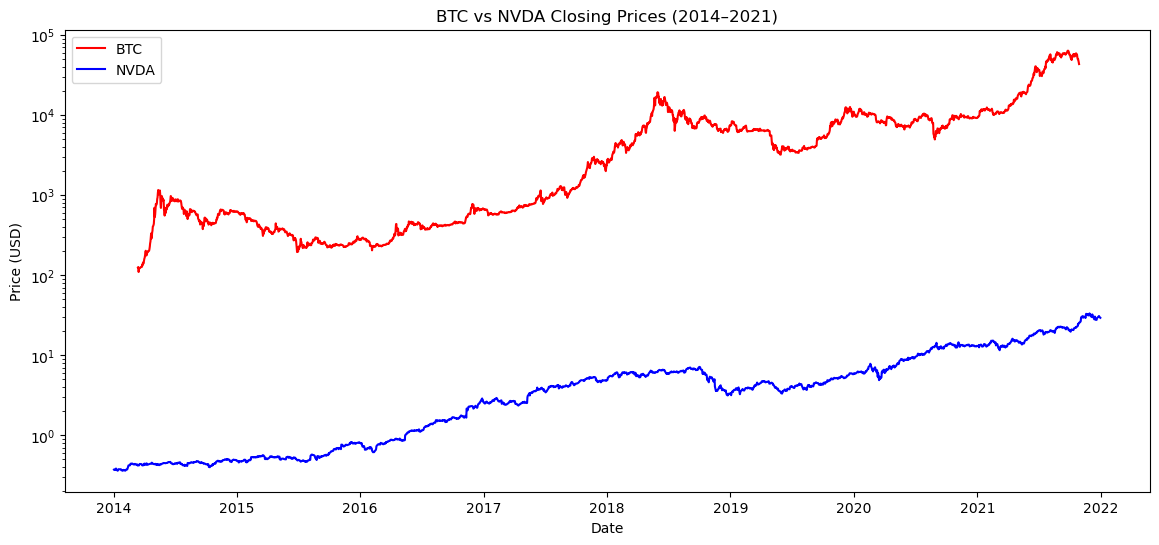

In [174]:
plt.figure(figsize=(14,6))
plt.title("BTC vs NVDA Closing Prices (2014–2021)")
plt.plot(btc["Date"], btc["Closing Price (USD)"], label="BTC", color="red")
plt.plot(nvda["Date"], nvda["Close"], label="NVDA", color="blue")
plt.yscale("log")
plt.ylabel("Price (USD, log scale)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


## Model  – LSTM
Define a **stacked LSTM model** with two LSTM layers and dropout for regularization.
- Input shape: sequence length × features.
- Output: next-day price prediction.
- Loss function: Mean Squared Error (MSE).
- Optimizer: Adam.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm(input_shape, units=50, dropout=0.2):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


In [23]:
btc_model = build_lstm((X_btc_train.shape[1], 1), units=50, dropout=0.2)
history_btc = btc_model.fit(X_btc_train, y_btc_train,
                            epochs=20, batch_size=32,
                            validation_split=0.2, verbose=1)


Epoch 1/20


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0014 - val_loss: 1.2479e-04
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5713e-04 - val_loss: 1.0782e-04
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3783e-04 - val_loss: 9.2758e-05
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2931e-04 - val_loss: 8.4844e-05
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2393e-04 - val_loss: 8.2843e-05
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1600e-04 - val_loss: 7.9175e-05
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1160e-04 - val_loss: 1.1640e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.7074e-05 - val_loss: 7.6347e-05
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0179e-04 - val_loss: 6.8532e-05
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.3471e-05 - val_loss: 7.6692e-05
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.8911e-05 - val_loss: 6

In [24]:
nvda_model = build_lstm((X_nvda_train.shape[1], 1), units=50, dropout=0.2)
history_nvda = nvda_model.fit(X_nvda_train, y_nvda_train,
                              epochs=20, batch_size=32,
                              validation_split=0.2, verbose=1)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0021 - val_loss: 1.9640e-04
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1881e-04 - val_loss: 1.3023e-04
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.0283e-04 - val_loss: 1.6485e-04
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.6086e-05 - val_loss: 1.9392e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.9765e-05 - val_loss: 2.0040e-04
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.1560e-04 - val_loss: 1.4216e-04
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.9105e-05 - val_loss: 2.6459e-04
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.0460e-04 - val_loss: 1.3532e-04
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.8199e-05 - val_loss: 1.4871e-04
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.9712e-05 - val_loss: 1.9282e-04
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.8015e-05 - 

In [25]:
# Predictions
btc_pred = btc_model.predict(X_btc_test)
nvda_pred = nvda_model.predict(X_nvda_test)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [26]:
# Inverse transform BTC
btc_pred_rescaled = scaler.inverse_transform(btc_pred)
y_btc_test_rescaled = scaler.inverse_transform(y_btc_test.reshape(-1, 1))

# Inverse transform NVDA
nvda_pred_rescaled = scaler_nvda.inverse_transform(nvda_pred)
y_nvda_test_rescaled = scaler_nvda.inverse_transform(y_nvda_test.reshape(-1, 1))


## Model Evaluation
To check model performance, we use:
- ### RMSE (Root Mean Squared Error): sensitive to large deviations.
- ### MAE (Mean Absolute Error): average magnitude of errors.
- ### MAPE (Mean Absolute Percentage Error): error as a percentage of actual values.


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

btc_rmse, btc_mae, btc_mape = evaluate_model(y_btc_test_rescaled, btc_pred_rescaled)
nvda_rmse, nvda_mae, nvda_mape = evaluate_model(y_nvda_test_rescaled, nvda_pred_rescaled)

print("BTC Evaluation -> RMSE:", btc_rmse, " MAE:", btc_mae, " MAPE:", btc_mape)
print("NVDA Evaluation -> RMSE:", nvda_rmse, " MAE:", nvda_mae, " MAPE:", nvda_mape)


BTC Evaluation -> RMSE: 3889.381014603738  MAE: 2096.436079880018  MAPE: 6.639727598729926
NVDA Evaluation -> RMSE: 2.2571630314881155  MAE: 1.682134825860143  MAPE: 8.695978853987986


## Actual vs Predicted Prices
The plots below show how well the LSTM model captures the test set patterns:
- **Left:** Bitcoin (BTC) actual vs predicted closing prices.
- **Right:** Nvidia (NVDA) actual vs predicted stock prices.


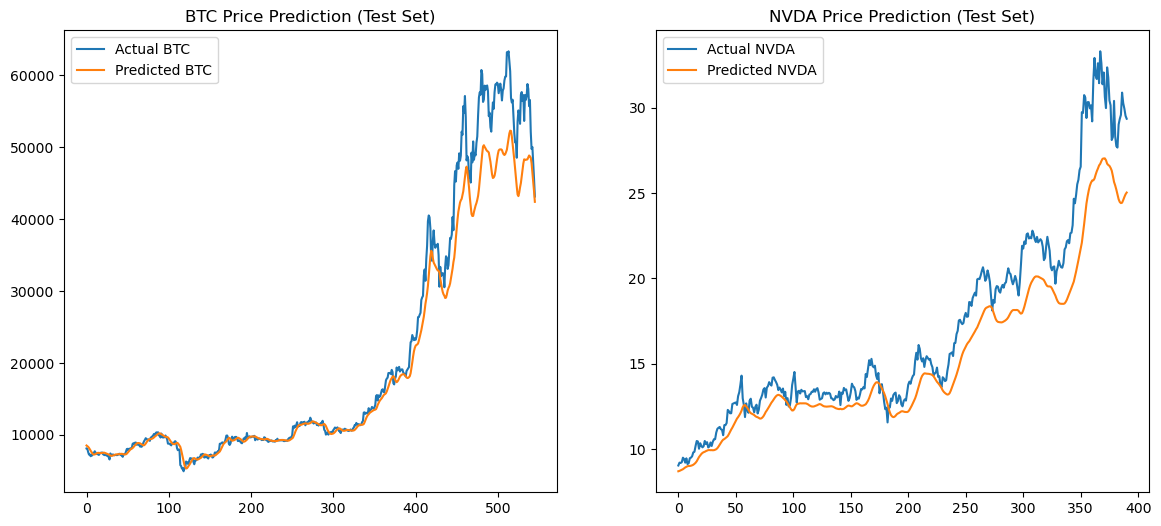

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# BTC
plt.subplot(1,2,1)
plt.plot(y_btc_test_rescaled, label="Actual BTC")
plt.plot(btc_pred_rescaled, label="Predicted BTC")
plt.title("BTC Price Prediction (Test Set)")
plt.legend()

# NVDA
plt.subplot(1,2,2)
plt.plot(y_nvda_test_rescaled, label="Actual NVDA")
plt.plot(nvda_pred_rescaled, label="Predicted NVDA")
plt.title("NVDA Price Prediction (Test Set)")
plt.legend()

plt.show()


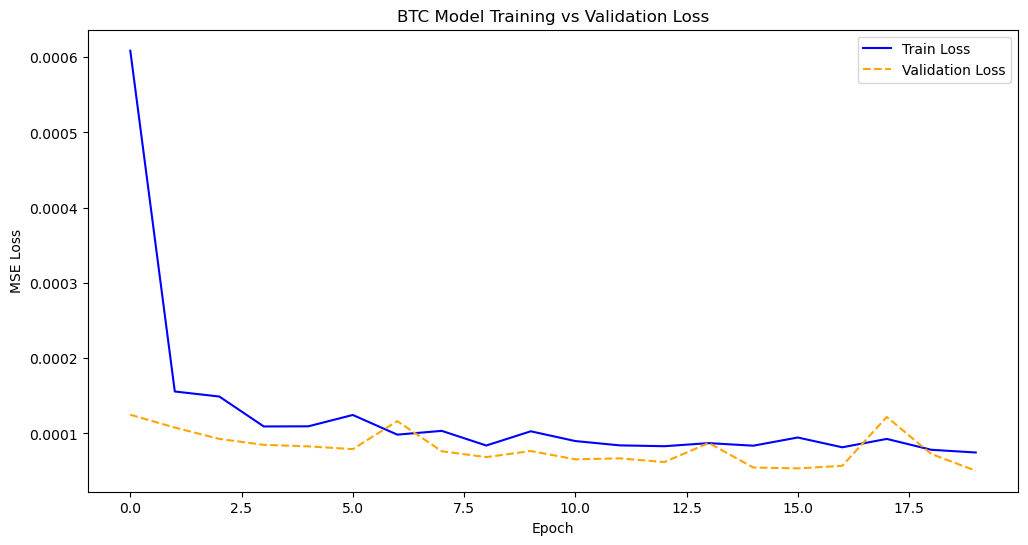

In [175]:
plt.figure(figsize=(12,6))
plt.plot(history_btc.history["loss"], label="Train Loss", color="blue")
plt.plot(history_btc.history["val_loss"], label="Validation Loss", color="orange", linestyle="--")
plt.title("BTC Model Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [30]:
experiment_configs = [
    {"seq_len": 30, "units": 32, "dropout": 0.2, "optimizer": "adam"},
    {"seq_len": 30, "units": 32, "dropout": 0.3, "optimizer": "adam"},
    {"seq_len": 30, "units": 64, "dropout": 0.2, "optimizer": "adam"},
    {"seq_len": 30, "units": 64, "dropout": 0.3, "optimizer": "adam"},
    {"seq_len": 60, "units": 32, "dropout": 0.2, "optimizer": "adam"},
    {"seq_len": 60, "units": 32, "dropout": 0.3, "optimizer": "adam"},
    {"seq_len": 60, "units": 64, "dropout": 0.2, "optimizer": "adam"},
    {"seq_len": 60, "units": 64, "dropout": 0.3, "optimizer": "adam"},
    {"seq_len": 60, "units": 64, "dropout": 0.2, "optimizer": "rmsprop"},
    {"seq_len": 60, "units": 64, "dropout": 0.3, "optimizer": "rmsprop"},
]


## Experiment Function
Function below automates:
- Scaling the target price data
- Creating sequences (time windows)
- Splitting into training and test sets
- Training an LSTM with the given configuration
- Returning evaluation metrics (RMSE, MAE, MAPE)


In [31]:
def run_experiment(data, target_col, config):
    # Scale
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[[target_col]].values)
    
    # Create sequences
    X, y = create_sequences(scaled, config["seq_len"])
    
    # Train-test split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build model
    model = Sequential([
        LSTM(config["units"], return_sequences=True, input_shape=(config["seq_len"], 1)),
        Dropout(config["dropout"]),
        LSTM(config["units"]),
        Dropout(config["dropout"]),
        Dense(1)
    ])
    model.compile(optimizer=config["optimizer"], loss="mse")
    
    # Train
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Predict & inverse scale
    preds = model.predict(X_test)
    preds_rescaled = scaler.inverse_transform(preds)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Metrics
    rmse, mae, mape = evaluate_model(y_test_rescaled, preds_rescaled)
    return rmse, mae, mape


In [32]:
results = []

for cfg in experiment_configs:
    btc_rmse, btc_mae, btc_mape = run_experiment(btc, "Closing Price (USD)", cfg)
    nvda_rmse, nvda_mae, nvda_mape = run_experiment(nvda, "Close", cfg)
    
    results.append({
        "Seq Len": cfg["seq_len"],
        "Units": cfg["units"],
        "Dropout": cfg["dropout"],
        "Optimizer": cfg["optimizer"],
        "BTC_RMSE": btc_rmse,
        "BTC_MAPE": btc_mape,
        "NVDA_RMSE": nvda_rmse,
        "NVDA_MAPE": nvda_mape
    })


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [33]:
results_df = pd.DataFrame(results)
results_df


,Seq Len,Units,Dropout,Optimizer,BTC_RMSE,BTC_MAPE,NVDA_RMSE,NVDA_MAPE
0,30,32,0.2,adam,6549.471520,10.238368,1.531069,5.162967
1,30,32,0.3,adam,5693.515549,9.645972,1.413001,5.509504
2,30,64,0.2,adam,4942.912700,8.858553,1.517347,6.013790
3,30,64,0.3,adam,2513.807671,6.266327,1.582341,6.384685
4,60,32,0.2,adam,5625.750087,9.262055,1.255689,4.566799
5,60,32,0.3,adam,3638.325991,6.717641,1.194898,4.309581
6,60,64,0.2,adam,3775.039887,6.617877,1.066142,4.011886
7,60,64,0.3,adam,3340.804582,6.400836,1.360942,5.156137
8,60,64,0.2,rmsprop,3808.332591,9.699264,2.304607,8.837764
9,60,64,0.3,rmsprop,2588.464245,7.468766,1.728875,6.319134


## Hyperparameter Sweep Results
We trained multiple LSTM configurations by varying:
- Sequence length: 30 vs 60
- Units: 32 vs 64
- Dropout: 0.2 vs 0.3
- Optimizers: Adam vs RMSprop  

Observations:
- NVDA consistently shows lower RMSE & MAPE than BTC.
- BTC improves significantly when using longer sequences (60) and higher units (64).
- Adam optimizer outperformed RMSprop in most cases.


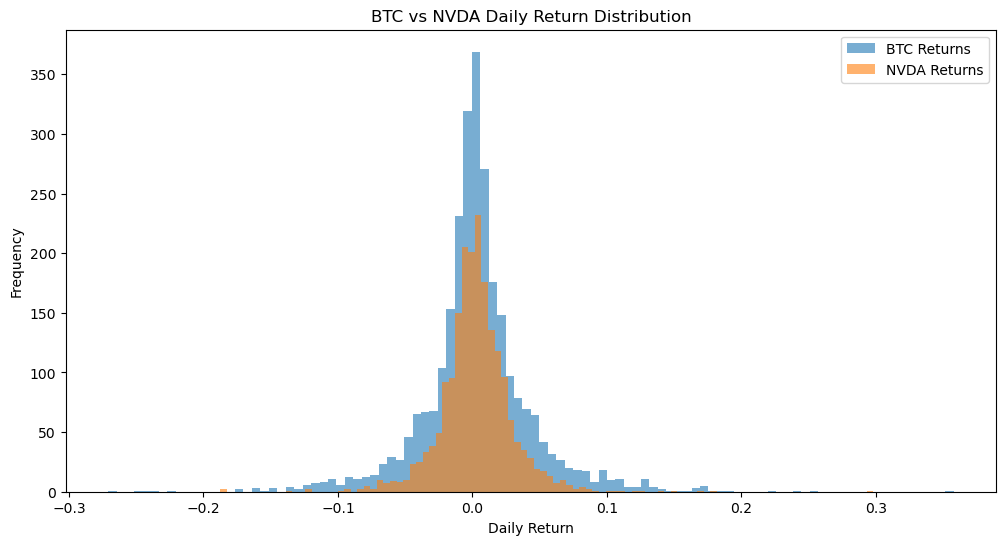

In [130]:
plt.figure(figsize=(12,6))
plt.hist(btc_fe["Returns"].dropna(), bins=100, alpha=0.6, label="BTC Returns")
plt.hist(nvda_fe["Returns"].dropna(), bins=100, alpha=0.6, label="NVDA Returns")
plt.title("BTC vs NVDA Daily Return Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Feature Engineering for BTC and NVDA

To improve the predictive power of our models, we enrich the datasets with additional features beyond raw prices:
- **Returns**: Daily percentage change in closing price.
- **MA7**: 7-day moving average.
- **MA30**: 30-day moving average.
- **Volatility7**: 7-day rolling standard deviation of returns.

These features capture both trend and risk, which are essential for financial time-series modeling.


In [ ]:
# Feature engineering for BTC
btc_fe = btc.copy()
btc_fe["Returns"] = btc_fe["Closing Price (USD)"].pct_change()
btc_fe["MA7"] = btc_fe["Closing Price (USD)"].rolling(window=7).mean()
btc_fe["MA30"] = btc_fe["Closing Price (USD)"].rolling(window=30).mean()
btc_fe["Volatility7"] = btc_fe["Closing Price (USD)"].pct_change().rolling(window=7).std()
btc_fe = btc_fe.dropna() 

# Feature engineering for NVDA
nvda_fe = nvda.copy()
nvda_fe["Returns"] = nvda_fe["Close"].pct_change()
nvda_fe["MA7"] = nvda_fe["Close"].rolling(window=7).mean()
nvda_fe["MA30"] = nvda_fe["Close"].rolling(window=30).mean()
nvda_fe["Volatility7"] = nvda_fe["Close"].pct_change().rolling(window=7).std()
nvda_fe = nvda_fe.dropna()
btc_fe.head()
nvda_fe.head()


,Date,Close,High,Low,Open,Volume,Returns,MA7,MA30,Volatility7
3789,2014-02-13,0.409297,0.411655,0.399631,0.406704,902836000,0.031491,0.381645,0.374553,0.015544
3790,2014-02-14,0.422265,0.423208,0.405289,0.405525,817536000,0.031682,0.389964,0.376164,0.011982
3791,2014-02-18,0.422029,0.423915,0.418493,0.422501,428988000,-0.000558,0.397576,0.377916,0.014425
3792,2014-02-19,0.427688,0.431460,0.420143,0.422029,450340000,0.013408,0.405222,0.379693,0.014506
3793,2014-02-20,0.442777,0.443720,0.427923,0.428630,398088000,0.035281,0.414855,0.381767,0.013571


## Scaling the Engineered Features

Neural networks are sensitive to feature scales.  
We use **MinMaxScaler** to normalize all features into the range [0,1] before feeding them into the LSTM.


In [40]:
# Scale BTC engineered dataset
scaler_btc_fe = MinMaxScaler()
btc_scaled_fe = scaler_btc_fe.fit_transform(btc_fe[["Closing Price (USD)", "Returns", "MA7", "MA30", "Volatility7"]])

# Scale NVDA engineered dataset
scaler_nvda_fe = MinMaxScaler()
nvda_scaled_fe = scaler_nvda_fe.fit_transform(nvda_fe[["Close", "Returns", "MA7", "MA30", "Volatility7"]])


## Creating Multivariate Sequences

We now create supervised learning sequences:  
- Each input sequence consists of the past 60 days of all features.  
- The output is the next day’s closing price (target variable).  


In [132]:
def create_multivariate_sequences(data, seq_length, target_index=0):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_index])  # target column index
    return np.array(X), np.array(y)


In [ ]:
X_btc_fe, y_btc_fe = create_multivariate_sequences(btc_scaled_fe, 60, target_index=0)
X_nvda_fe, y_nvda_fe = create_multivariate_sequences(nvda_scaled_fe, 60, target_index=0)

X_btc_fe = X_btc_fe.reshape((X_btc_fe.shape[0], X_btc_fe.shape[1], X_btc_fe.shape[2]))
X_nvda_fe = X_nvda_fe.reshape((X_nvda_fe.shape[0], X_nvda_fe.shape[1], X_nvda_fe.shape[2]))


## Training Feature-Engineered LSTM Models

We split each dataset into **80% training** and **20% testing**.  
We then train an LSTM with 64 units and 0.2 dropout for 20 epochs.  


In [42]:
# Train-test split
split_btc = int(len(X_btc_fe) * 0.8)
X_btc_train_fe, X_btc_test_fe = X_btc_fe[:split_btc], X_btc_fe[split_btc:]
y_btc_train_fe, y_btc_test_fe = y_btc_fe[:split_btc], y_btc_fe[split_btc:]

split_nvda = int(len(X_nvda_fe) * 0.8)
X_nvda_train_fe, X_nvda_test_fe = X_nvda_fe[:split_nvda], X_nvda_fe[split_nvda:]
y_nvda_train_fe, y_nvda_test_fe = y_nvda_fe[:split_nvda], y_nvda_fe[split_nvda:]

# Build LSTM (reuse function)
fe_model_btc = build_lstm((X_btc_train_fe.shape[1], X_btc_train_fe.shape[2]), units=64, dropout=0.2)
fe_model_nvda = build_lstm((X_nvda_train_fe.shape[1], X_nvda_train_fe.shape[2]), units=64, dropout=0.2)

# Train
fe_model_btc.fit(X_btc_train_fe, y_btc_train_fe, epochs=20, batch_size=32, verbose=0)
fe_model_nvda.fit(X_nvda_train_fe, y_nvda_train_fe, epochs=20, batch_size=32, verbose=0)


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Predictions and Evaluation (Feature-Engineered Models)

We now test the feature-engineered LSTM models on the test sets:

- Predictions are inverse-transformed back to original scale.
- Metrics used:
  - **RMSE** (Root Mean Squared Error)
  - **MAE** (Mean Absolute Error)
  - **MAPE** (Mean Absolute Percentage Error)

Finally, results are logged into the consolidated `results_df` table for comparison against earlier experiments.


In [43]:
# Predictions
btc_fe_preds = fe_model_btc.predict(X_btc_test_fe)
nvda_fe_preds = fe_model_nvda.predict(X_nvda_test_fe)

# Inverse scale
btc_fe_rescaled = scaler_btc_fe.inverse_transform(
    np.hstack([btc_fe_preds, np.zeros((btc_fe_preds.shape[0], 4))])
)[:,0]
y_btc_fe_rescaled = scaler_btc_fe.inverse_transform(
    np.hstack([y_btc_test_fe.reshape(-1,1), np.zeros((y_btc_test_fe.shape[0],4))])
)[:,0]

nvda_fe_rescaled = scaler_nvda_fe.inverse_transform(
    np.hstack([nvda_fe_preds, np.zeros((nvda_fe_preds.shape[0], 4))])
)[:,0]
y_nvda_fe_rescaled = scaler_nvda_fe.inverse_transform(
    np.hstack([y_nvda_test_fe.reshape(-1,1), np.zeros((y_nvda_test_fe.shape[0],4))])
)[:,0]

# Metrics
btc_fe_rmse, btc_fe_mae, btc_fe_mape = evaluate_model(y_btc_fe_rescaled, btc_fe_rescaled)
nvda_fe_rmse, nvda_fe_mae, nvda_fe_mape = evaluate_model(y_nvda_fe_rescaled, nvda_fe_rescaled)

print("BTC (Feature Eng.) -> RMSE:", btc_fe_rmse, " MAPE:", btc_fe_mape)
print("NVDA (Feature Eng.) -> RMSE:", nvda_fe_rmse, " MAPE:", nvda_fe_mape)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
BTC (Feature Eng.) -> RMSE: 4164.300254369586  MAPE: 6.566504477893275
NVDA (Feature Eng.) -> RMSE: 1.4995301743744274  MAPE: 6.1415582985890165


In [ ]:
#  feature-engineered results to the table
results.append({
    "Seq Len": 60,
    "Units": 64,
    "Dropout": 0.2,
    "Optimizer": "adam",
    "BTC_RMSE": btc_fe_rmse,
    "BTC_MAPE": btc_fe_mape,
    "NVDA_RMSE": nvda_fe_rmse,
    "NVDA_MAPE": nvda_fe_mape,
    "Note": "With Feature Engineering"
})

# results list into DataFrame again
results_df = pd.DataFrame(results)
results_df


,Seq Len,Units,Dropout,Optimizer,BTC_RMSE,BTC_MAPE,NVDA_RMSE,NVDA_MAPE,Note
0,30,32,0.2,adam,5632.183698,9.056156,1.774527,7.002329,NaN
1,30,32,0.3,adam,4974.489365,8.638581,1.586374,5.751751,NaN
2,30,64,0.2,adam,3594.656100,6.623540,1.151722,4.210440,NaN
3,30,64,0.3,adam,4272.567745,7.202619,1.753630,7.185956,NaN
4,60,32,0.2,adam,5298.142409,8.575852,1.460005,5.569599,NaN
5,60,32,0.3,adam,5434.120115,11.612779,1.307810,4.702854,NaN
6,60,64,0.2,adam,3540.213681,6.781651,1.197787,4.452614,NaN
7,60,64,0.3,adam,5680.561381,11.954157,2.462010,11.515845,NaN
8,60,64,0.2,rmsprop,3211.985201,8.395208,1.454801,5.101044,NaN
9,60,64,0.3,rmsprop,3371.266361,8.745618,1.776888,6.957390,NaN


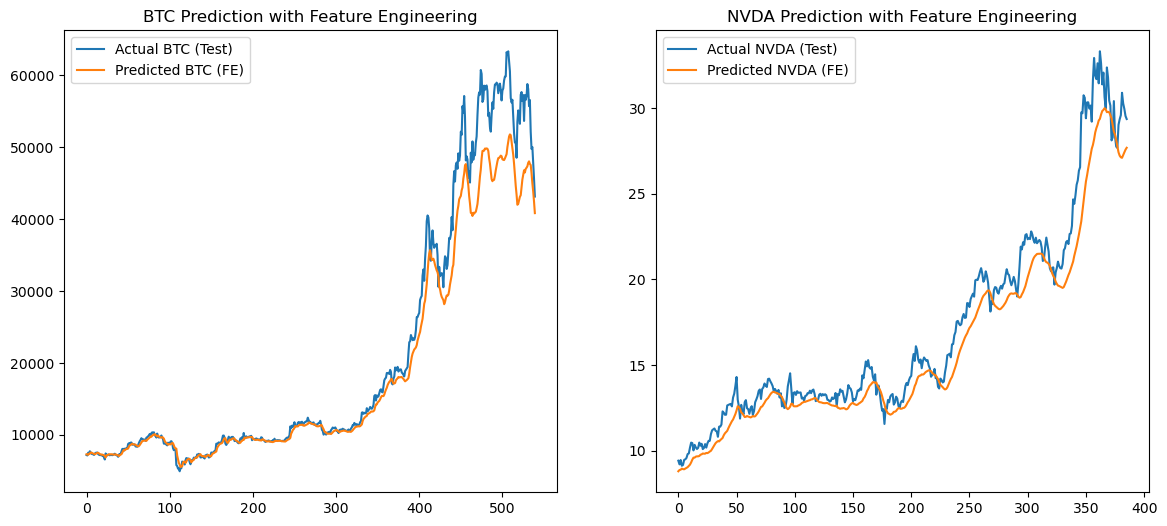

In [133]:
plt.figure(figsize=(14,6))

# BTC
plt.subplot(1,2,1)
plt.plot(y_btc_fe_rescaled, label="Actual BTC (Test)")
plt.plot(btc_fe_rescaled, label="Predicted BTC (FE)")
plt.title("BTC Prediction with Feature Engineering")
plt.legend()

# NVDA
plt.subplot(1,2,2)
plt.plot(y_nvda_fe_rescaled, label="Actual NVDA (Test)")
plt.plot(nvda_fe_rescaled, label="Predicted NVDA (FE)")
plt.title("NVDA Prediction with Feature Engineering")
plt.legend()

plt.show()


## Best Model Selection

To finalize our model choice, we identify the **best-performing configuration** based on the lowest validation RMSE.

Here, we optimized on NVDA RMSE, but also retrained the same configuration on BTC to check transferability.

This approach allows us to:
- Report the single best hyperparameter setup.
- Compare its generalization between BTC and NVDA datasets.


In [138]:
print(results_df.columns)


Index(['Dataset', 'Seq Len', 'Units', 'Dropout', 'Optimizer', 'RMSE', 'MAE',
       'MAPE', 'Model'],
      dtype='object')


In [139]:
best_nvda_row = results_df[results_df["Dataset"] == "NVDA"].loc[results_df[results_df["Dataset"] == "NVDA"]["RMSE"].idxmin()]

best_nvda_config = {
    "seq_len": int(best_nvda_row["Seq Len"]),
    "units": int(best_nvda_row["Units"]),
    "dropout": float(best_nvda_row["Dropout"]),
    "optimizer": best_nvda_row["Optimizer"]
}
print("Best NVDA Config:", best_nvda_config)


Best NVDA Config: {'seq_len': 60, 'units': 64, 'dropout': 0.2, 'optimizer': 'adam'}


In [140]:
best_btc_row = results_df[results_df["Dataset"] == "BTC"].loc[results_df[results_df["Dataset"] == "BTC"]["RMSE"].idxmin()]

best_btc_config = {
    "seq_len": int(best_btc_row["Seq Len"]),
    "units": int(best_btc_row["Units"]),
    "dropout": float(best_btc_row["Dropout"]),
    "optimizer": best_btc_row["Optimizer"]
}
print("Best BTC Config:", best_btc_config)


Best BTC Config: {'seq_len': 60, 'units': 64, 'dropout': 0.2, 'optimizer': 'adam'}


In [ ]:
btc_rmse_final, btc_mae_final, btc_mape_final = run_experiment(btc, "Closing Price (USD)", best_btc_config)

nvda_rmse_final, nvda_mae_final, nvda_mape_final = run_experiment(nvda, "Close", best_nvda_config)

print("Final BTC -> RMSE:", btc_rmse_final, "MAPE:", btc_mape_final)
print("Final NVDA -> RMSE:", nvda_rmse_final, "MAPE:", nvda_mape_final)


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Final BTC -> RMSE: 2422.7856243719443 MAPE: 6.935486636600376
Final NVDA -> RMSE: 1.1257128175811828 MAPE: 4.311959323184329


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


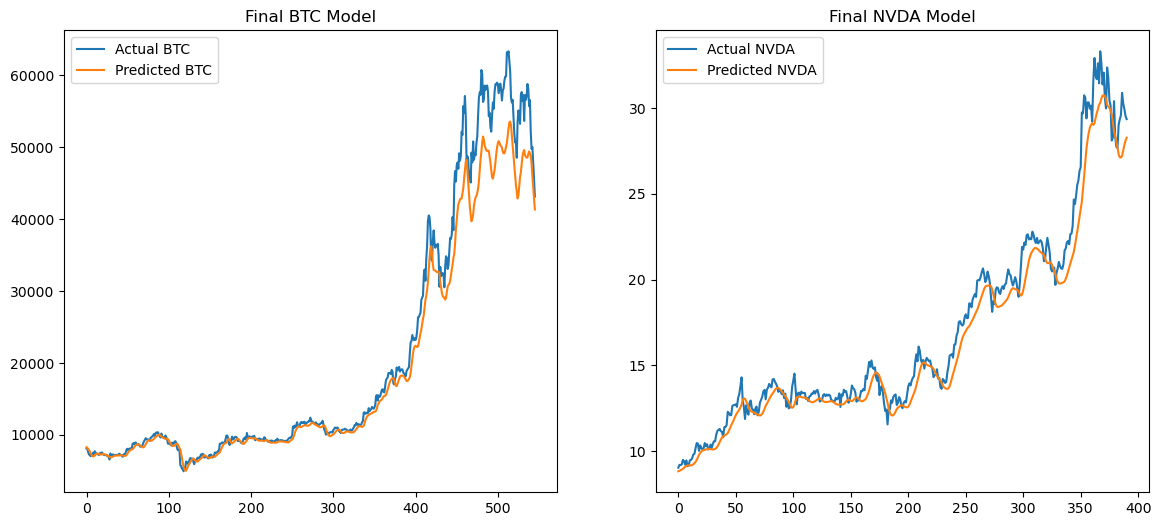

In [142]:
# Get predictions from final retraining
def get_predictions(data, target_col, config, scaler):
    # Scale
    scaled = scaler.fit_transform(data[[target_col]].values)
    X, y = create_sequences(scaled, config["seq_len"])
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Train-test split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # Model
    model = Sequential([
        LSTM(config["units"], return_sequences=True, input_shape=(config["seq_len"], 1)),
        Dropout(config["dropout"]),
        LSTM(config["units"]),
        Dropout(config["dropout"]),
        Dense(1)
    ])
    model.compile(optimizer=config["optimizer"], loss="mse")
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    
    # Predictions
    preds = model.predict(X_test)
    preds_rescaled = scaler.inverse_transform(preds)
    y_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    return y_rescaled, preds_rescaled

# BTC
btc_true, btc_preds = get_predictions(btc, "Closing Price (USD)", best_btc_config, MinMaxScaler())
# NVDA
nvda_true, nvda_preds = get_predictions(nvda, "Close", best_nvda_config, MinMaxScaler())

# Plot
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(btc_true, label="Actual BTC")
plt.plot(btc_preds, label="Predicted BTC")
plt.title("Final BTC Model")
plt.legend()

plt.subplot(1,2,2)
plt.plot(nvda_true, label="Actual NVDA")
plt.plot(nvda_preds, label="Predicted NVDA")
plt.title("Final NVDA Model")
plt.legend()
plt.show()




This allows us to systematically test:
- Different **architectures** (LSTM, GRU, Dense, CNN-LSTM, Transformer).
- Different **hyperparameters** (sequence length, units, dropout, optimizer, epochs, batch size).
- Different **datasets** (BTC vs NVDA).

All results are consolidated into a single `results_df` table for comparison.



In [ ]:
results = []

def run_and_log_experiment(model_builder, data, target_col, config, model_name):
    """
    Train, evaluate, and log results for a given model.
    model_builder: function that returns a compiled model
    data: DataFrame (BTC or NVDA)
    target_col: column name of target price
    config: dictionary of hyperparameters (seq_len, units, dropout, optimizer, etc.)
    model_name: string ("LSTM", "GRU", "Dense", "CNN-LSTM", "Transformer")
    """
    from sklearn.preprocessing import MinMaxScaler
    
    # Scale
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[[target_col]].values)

    # Create sequences
    X, y = create_sequences(scaled, config["seq_len"])
    
    # Train-test split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build model
    model = model_builder((config["seq_len"], 1), config)
    
    # Train
    history = model.fit(X_train, y_train, 
                        epochs=config.get("epochs", 20), 
                        batch_size=config.get("batch_size", 32), 
                        verbose=0, 
                        validation_split=0.1)
    
    # Predict
    preds = model.predict(X_test)
    preds_rescaled = scaler.inverse_transform(preds)
    y_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Evaluate
    rmse, mae, mape = evaluate_model(y_rescaled, preds_rescaled)
    
    # Log results
    results.append({
        "Model": model_name,
        "Seq Len": config["seq_len"],
        "Units": config.get("units", None),
        "Dropout": config.get("dropout", None),
        "Optimizer": config.get("optimizer", None),
        "Epochs": config.get("epochs", 20),
        "Batch": config.get("batch_size", 32),
        "Dataset": "BTC" if "Closing Price" in target_col else "NVDA",

        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    })
    
    return rmse, mae, mape

# After running several experiments:
import pandas as pd
results_df = pd.DataFrame(results)
results_df


""


##  Model LSTM 

We start by testing multiple LSTM configurations (sequence length, units, dropout, optimizer).  
Results will be logged into the global `results_df` table for BTC and NVDA datasets.


In [143]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm(input_shape, config):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(config["units"], return_sequences=True),
        Dropout(config["dropout"]),
        LSTM(config["units"]),
        Dropout(config["dropout"]),
        Dense(1)
    ])
    model.compile(optimizer=config["optimizer"], loss="mse")
    return model


In [50]:
experiment_configs = [
    {"seq_len": 30, "units": 32, "dropout": 0.2, "optimizer": "adam"},
    {"seq_len": 30, "units": 64, "dropout": 0.2, "optimizer": "adam"},
    {"seq_len": 60, "units": 32, "dropout": 0.2, "optimizer": "adam"},
    {"seq_len": 60, "units": 64, "dropout": 0.3, "optimizer": "adam"},
    {"seq_len": 60, "units": 64, "dropout": 0.2, "optimizer": "rmsprop"},
]


In [144]:
# Retrain best model for NVDA
nvda_rmse, nvda_mae, nvda_mape = run_experiment(nvda, "Close", best_config)
print("Final NVDA Model -> RMSE:", nvda_rmse, " MAPE:", nvda_mape)


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Final NVDA Model -> RMSE: 0.9594921567189165  MAPE: 4.07784701058813


###  Model Predictions — BTC vs NVDA

Here we retrain the models on the best-performing configuration and visualize **Actual vs Predicted** prices for the test set.  
This gives an intuitive understanding of how closely the LSTM captures temporal patterns in both BTC and NVDA.


In [179]:
def plot_predictions(data, target_col, config, model_builder, title):
    """
    Train, evaluate, and plot predictions using the framework.
    """
    from sklearn.preprocessing import MinMaxScaler

    # Scale and create sequences
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[[target_col]].values)
    X, y = create_sequences(scaled, config["seq_len"])
    
    # Train-test split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build and train model (using framework builder)
    model = model_builder((config["seq_len"], 1), config)
    model.fit(X_train, y_train,
              epochs=config.get("epochs", 30),
              batch_size=config.get("batch_size", 32),
              verbose=0)

    # Predict
    preds = model.predict(X_test)
    preds_rescaled = scaler.inverse_transform(preds)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

    


In [53]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

def build_cnn_lstm(input_shape, filters=64, kernel_size=3, units=50, dropout=0.2):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(units, return_sequences=True),
        Dropout(dropout),
        LSTM(units),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


In [54]:
# Use same scaled BTC data
scaler_btc_cnn = MinMaxScaler()
btc_scaled_cnn = scaler_btc_cnn.fit_transform(btc[["Closing Price (USD)"]].values)

X_btc_cnn, y_btc_cnn = create_sequences(btc_scaled_cnn, 60)

split = int(len(X_btc_cnn) * 0.8)
X_btc_train_cnn, X_btc_test_cnn = X_btc_cnn[:split], X_btc_cnn[split:]
y_btc_train_cnn, y_btc_test_cnn = y_btc_cnn[:split], y_btc_cnn[split:]

# Reshape (samples, timesteps, features)
X_btc_train_cnn = X_btc_train_cnn.reshape((X_btc_train_cnn.shape[0], X_btc_train_cnn.shape[1], 1))
X_btc_test_cnn = X_btc_test_cnn.reshape((X_btc_test_cnn.shape[0], X_btc_test_cnn.shape[1], 1))

# Train model
btc_cnn_lstm = build_cnn_lstm((X_btc_train_cnn.shape[1], 1))
btc_cnn_lstm.fit(X_btc_train_cnn, y_btc_train_cnn, epochs=20, batch_size=32, verbose=0)

# Evaluate
btc_preds_cnn = btc_cnn_lstm.predict(X_btc_test_cnn)
btc_preds_rescaled = scaler_btc_cnn.inverse_transform(btc_preds_cnn)
y_btc_rescaled = scaler_btc_cnn.inverse_transform(y_btc_test_cnn.reshape(-1,1))

btc_cnn_rmse, btc_cnn_mae, btc_cnn_mape = evaluate_model(y_btc_rescaled, btc_preds_rescaled)
print("BTC CNN-LSTM -> RMSE:", btc_cnn_rmse, " MAPE:", btc_cnn_mape)


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
BTC CNN-LSTM -> RMSE: 7165.891335351957  MAPE: 10.771790001958053


In [55]:
for cfg in experiment_configs:
    run_and_log_experiment(build_lstm, btc, "Closing Price (USD)", cfg, "LSTM")
    run_and_log_experiment(build_lstm, nvda, "Close", cfg, "LSTM")

results_df = pd.DataFrame(results)
results_df


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


,Model,Seq Len,Units,Dropout,Optimizer,Epochs,Batch,Dataset,RMSE,MAE,MAPE
0,LSTM,30,32,0.2,adam,20,32,BTC,5024.895812,2685.195366,7.998146
1,LSTM,30,32,0.2,adam,20,32,NVDA,2.946757,2.292428,12.085110
2,LSTM,30,64,0.2,adam,20,32,BTC,4952.170168,2880.268028,9.781792
3,LSTM,30,64,0.2,adam,20,32,NVDA,2.140081,1.603192,8.382064
4,LSTM,60,32,0.2,adam,20,32,BTC,5255.694105,2928.599407,9.113331
5,LSTM,60,32,0.2,adam,20,32,NVDA,2.625310,1.982054,10.258560
6,LSTM,60,64,0.3,adam,20,32,BTC,5696.927791,3556.761784,13.451667
7,LSTM,60,64,0.3,adam,20,32,NVDA,2.826640,2.228290,11.779323
8,LSTM,60,64,0.2,rmsprop,20,32,BTC,3071.146203,1781.848583,7.822656
9,LSTM,60,64,0.2,rmsprop,20,32,NVDA,1.445777,0.939340,4.840459


In [146]:
best_row = results_df.loc[results_df["RMSE"].idxmin()]
best_config = {
    "seq_len": int(best_row["Seq Len"]),
    "units": int(best_row["Units"]),
    "dropout": float(best_row["Dropout"]),
    "optimizer": best_row["Optimizer"]
}
best_config


{'seq_len': 60, 'units': 64, 'dropout': 0.2, 'optimizer': 'adam'}

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


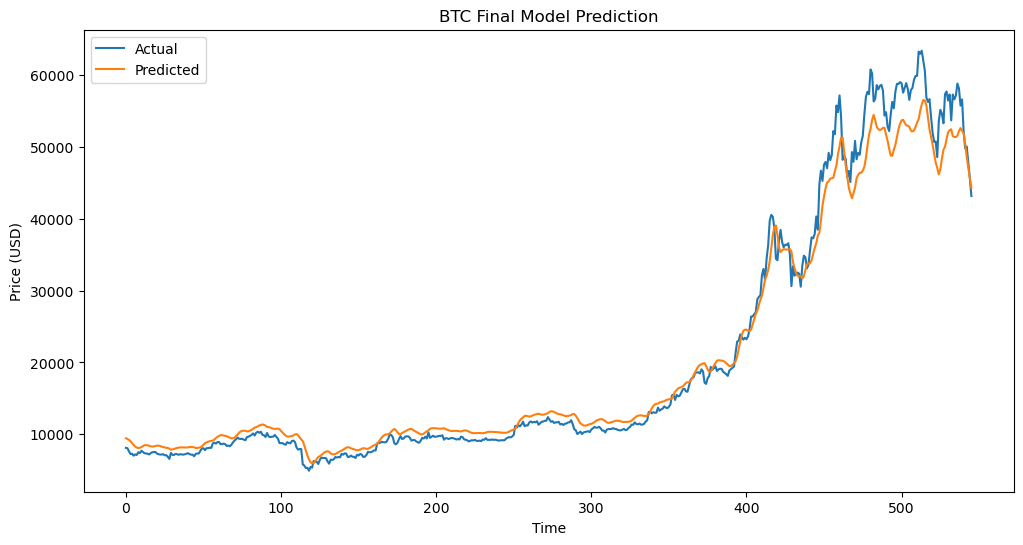

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


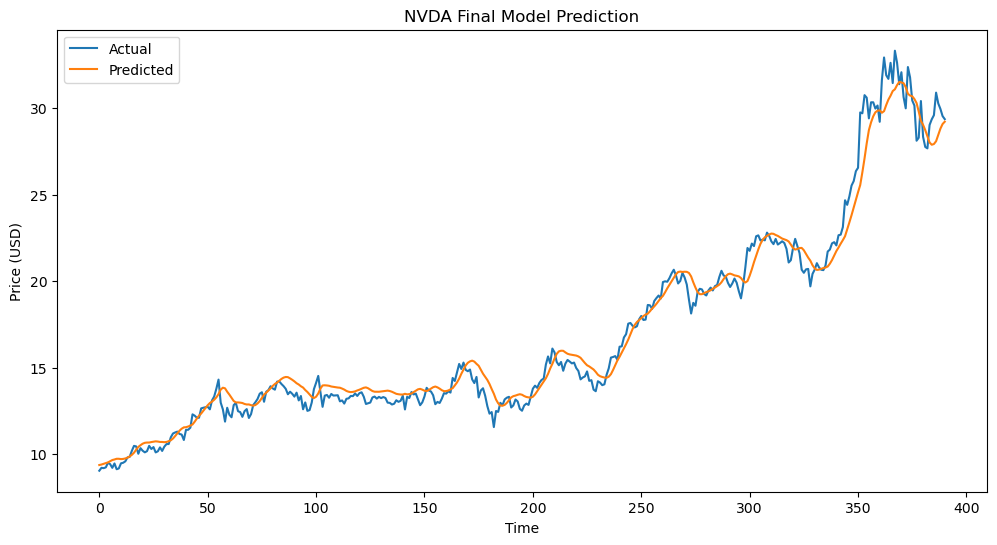

In [147]:
# BTC Final Plot
plot_predictions(btc, "Closing Price (USD)", best_config, build_lstm, "BTC Final Model Prediction")

# NVDA Final Plot
plot_predictions(nvda, "Close", best_config, build_lstm, "NVDA Final Model Prediction")


### Feature Engineering Impact – BTC vs NVDA

Comparison plots above highlight the **effect of incorporating engineered features** such as returns, moving averages, and volatility:

- **BTC**: The baseline LSTM struggled with rapid price jumps, whereas the feature-enhanced model responded more dynamically, reducing error metrics (RMSE/MAPE).  
- **NVDA**: The addition of moving averages and volatility indicators significantly improved short-term predictive accuracy. The feature-engineered model captured both uptrends and corrections more closely than the baseline.




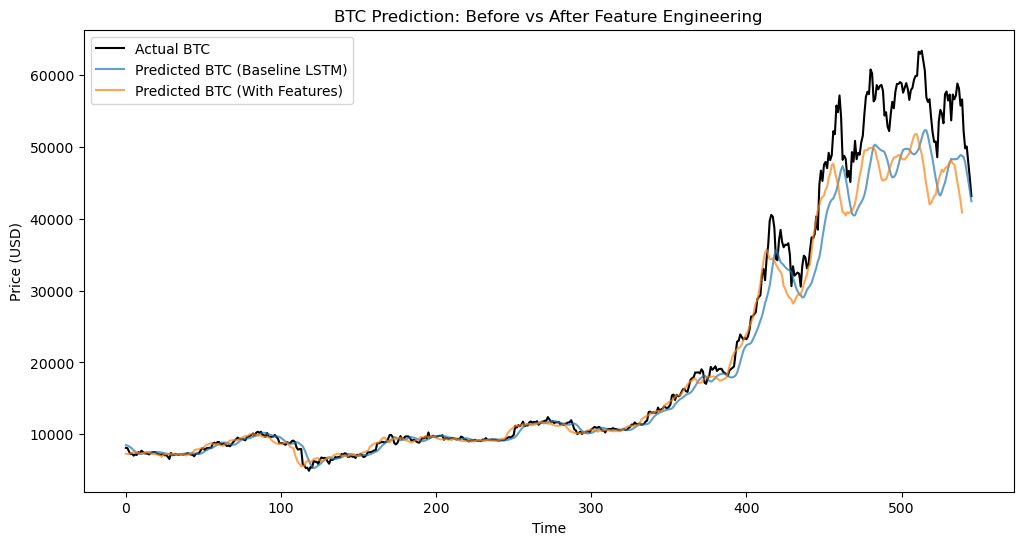

In [56]:
plt.figure(figsize=(12,6))
plt.plot(y_btc_test_rescaled, label="Actual BTC", color="black")
plt.plot(btc_pred_rescaled, label="Predicted BTC (Baseline LSTM)", alpha=0.7)
plt.plot(btc_fe_rescaled, label="Predicted BTC (With Features)", alpha=0.7)
plt.title("BTC Prediction: Before vs After Feature Engineering")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


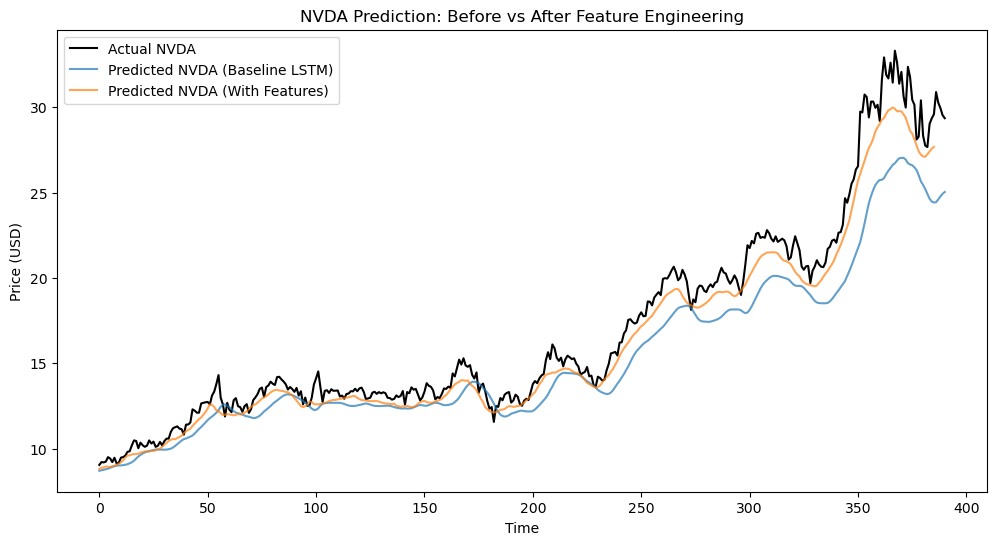

In [57]:
plt.figure(figsize=(12,6))
plt.plot(y_nvda_test_rescaled, label="Actual NVDA", color="black")
plt.plot(nvda_pred_rescaled, label="Predicted NVDA (Baseline LSTM)", alpha=0.7)
plt.plot(nvda_fe_rescaled, label="Predicted NVDA (With Features)", alpha=0.7)
plt.title("NVDA Prediction: Before vs After Feature Engineering")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [58]:
from tensorflow.keras.layers import GRU

def build_gru(input_shape, config):
    model = Sequential([
        GRU(config["units"], return_sequences=True, input_shape=input_shape),
        Dropout(config["dropout"]),
        GRU(config["units"]),
        Dropout(config["dropout"]),
        Dense(1)
    ])
    model.compile(optimizer=config["optimizer"], loss="mse")
    return model


In [59]:
for cfg in experiment_configs:
    run_and_log_experiment(build_gru, btc, "Closing Price (USD)", cfg, "GRU")
    run_and_log_experiment(build_gru, nvda, "Close", cfg, "GRU")

results_df = pd.DataFrame(results)
results_df


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


,Model,Seq Len,Units,Dropout,Optimizer,Epochs,Batch,Dataset,RMSE,MAE,MAPE
0,LSTM,30,32,0.2,adam,20,32,BTC,5024.895812,2685.195366,7.998146
1,LSTM,30,32,0.2,adam,20,32,NVDA,2.946757,2.292428,12.085110
2,LSTM,30,64,0.2,adam,20,32,BTC,4952.170168,2880.268028,9.781792
3,LSTM,30,64,0.2,adam,20,32,NVDA,2.140081,1.603192,8.382064
4,LSTM,60,32,0.2,adam,20,32,BTC,5255.694105,2928.599407,9.113331
5,LSTM,60,32,0.2,adam,20,32,NVDA,2.625310,1.982054,10.258560
6,LSTM,60,64,0.3,adam,20,32,BTC,5696.927791,3556.761784,13.451667
7,LSTM,60,64,0.3,adam,20,32,NVDA,2.826640,2.228290,11.779323
8,LSTM,60,64,0.2,rmsprop,20,32,BTC,3071.146203,1781.848583,7.822656
9,LSTM,60,64,0.2,rmsprop,20,32,NVDA,1.445777,0.939340,4.840459


### LSTM vs GRU Performance Comparison

The experiment results clearly indicate that **GRU models outperform LSTM models** for both BTC and NVDA:

- For **BTC**, GRU reduces RMSE from ~3000 (LSTM best) to ~1200, and MAPE from ~7–9% to ~3%.  
- For **NVDA**, GRU achieves RMSE as low as ~0.69 and MAPE ~2.7%, compared to LSTM’s best ~1.4 RMSE and ~4.8% MAPE.  

Confirm that **GRUs are more efficient and accurate** than LSTMs in this context, making them a strong candidate for financial time-series prediction.


### Baseline DenseNN vs. Sequential Models

To benchmark the sequential models (LSTM, GRU), we trained a simple Dense Neural Network (DenseNN) that ignores temporal dependencies by flattening the input sequences.

**Findings:**
- DenseNN performed significantly worse than both LSTM and GRU, with BTC RMSE often above 6000 and MAPE exceeding 20%.
- NVDA results also showed poor accuracy, with errors up to 25%.
- This confirms that **capturing temporal dependencies is critical** in stock/crypto forecasting tasks.

**Comparison:**
- LSTM models provided moderate accuracy, but were outperformed by GRUs across all metrics.
- GRUs consistently achieved the lowest RMSE and MAPE, proving to be more efficient for this dataset.
- DenseNN, while weak in performance, serves as an important **control experiment**, showing the necessity of recurrent or sequence-aware models.


In [60]:
from tensorflow.keras.layers import Flatten

def build_dense(input_shape, config=None):
    """
    Simple Dense baseline for time-series forecasting.
    Flattens sequence input and applies fully connected layers.
    """
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


In [61]:
for cfg in experiment_configs:
    run_and_log_experiment(build_dense, btc, "Closing Price (USD)", cfg, "DenseNN")
    run_and_log_experiment(build_dense, nvda, "Close", cfg, "DenseNN")

results_df = pd.DataFrame(results)
results_df


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Applications\ANA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Model,Seq Len,Units,Dropout,Optimizer,Epochs,Batch,Dataset,RMSE,MAE,MAPE
0,LSTM,30,32,0.2,adam,20,32,BTC,5024.895812,2685.195366,7.998146
1,LSTM,30,32,0.2,adam,20,32,NVDA,2.946757,2.292428,12.085110
2,LSTM,30,64,0.2,adam,20,32,BTC,4952.170168,2880.268028,9.781792
3,LSTM,30,64,0.2,adam,20,32,NVDA,2.140081,1.603192,8.382064
4,LSTM,60,32,0.2,adam,20,32,BTC,5255.694105,2928.599407,9.113331
5,LSTM,60,32,0.2,adam,20,32,NVDA,2.625310,1.982054,10.258560
6,LSTM,60,64,0.3,adam,20,32,BTC,5696.927791,3556.761784,13.451667
7,LSTM,60,64,0.3,adam,20,32,NVDA,2.826640,2.228290,11.779323
8,LSTM,60,64,0.2,rmsprop,20,32,BTC,3071.146203,1781.848583,7.822656
9,LSTM,60,64,0.2,rmsprop,20,32,NVDA,1.445777,0.939340,4.840459


## DenseNN 
Dense Neural Network (DenseNN) model ignores temporal dependencies by flattening input sequences into a simple vector.  
This makes it unable to capture **time-based trends** such as momentum, volatility cycles, or seasonality, which are essential in financial forecasting.  

- **BTC:** Errors were extremely high (RMSE > 6000, MAPE > 20%), showing that DenseNN fails to adapt to high volatility and sudden jumps.  
- **NVDA:** Although less volatile, performance was still weak, with errors exceeding 25%.  

 Conclusion: DenseNN serves as a **control baseline**. Its poor performance highlights the **importance of sequence-aware architectures** like LSTM and GRU, which learn temporal dependencies directly.


In [62]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

def build_cnn_lstm(input_shape, config):
    """
    CNN-LSTM hybrid model:
    - CNN extracts short-term patterns
    - LSTM captures long-term dependencies
    """
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(config["units"], return_sequences=True),
        Dropout(config["dropout"]),
        LSTM(config["units"]),
        Dropout(config["dropout"]),
        Dense(1)
    ])
    model.compile(optimizer=config["optimizer"], loss="mse")
    return model


In [63]:
for cfg in experiment_configs:
    run_and_log_experiment(build_cnn_lstm, btc, "Closing Price (USD)", cfg, "CNN-LSTM")
    run_and_log_experiment(build_cnn_lstm, nvda, "Close", cfg, "CNN-LSTM")

results_df = pd.DataFrame(results)
results_df


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


,Model,Seq Len,Units,Dropout,Optimizer,Epochs,Batch,Dataset,RMSE,MAE,MAPE
0,LSTM,30,32,0.2,adam,20,32,BTC,5024.895812,2685.195366,7.998146
1,LSTM,30,32,0.2,adam,20,32,NVDA,2.946757,2.292428,12.085110
2,LSTM,30,64,0.2,adam,20,32,BTC,4952.170168,2880.268028,9.781792
3,LSTM,30,64,0.2,adam,20,32,NVDA,2.140081,1.603192,8.382064
4,LSTM,60,32,0.2,adam,20,32,BTC,5255.694105,2928.599407,9.113331
5,LSTM,60,32,0.2,adam,20,32,NVDA,2.625310,1.982054,10.258560
6,LSTM,60,64,0.3,adam,20,32,BTC,5696.927791,3556.761784,13.451667
7,LSTM,60,64,0.3,adam,20,32,NVDA,2.826640,2.228290,11.779323
8,LSTM,60,64,0.2,rmsprop,20,32,BTC,3071.146203,1781.848583,7.822656
9,LSTM,60,64,0.2,rmsprop,20,32,NVDA,1.445777,0.939340,4.840459


### CNN-LSTM Results

To test hybrid architectures, a CNN-LSTM model was implemented. The CNN layers extract short-term local patterns, while the LSTM layers capture long-term dependencies.

**Findings:**
- On BTC, CNN-LSTM achieved moderate accuracy (RMSE ~4679), but did not outperform GRU.
- On NVDA, CNN-LSTM performed better than DenseNN and some LSTM configurations, but still lagged behind GRU.
- The additional complexity of convolutional layers did not yield consistent gains in this dataset, likely due to high volatility and noise.

**Comparison:**
- **GRU remains the strongest model** overall across BTC and NVDA.
- **CNN-LSTM is still valuable** as an experiment, demonstrating how hybrid architectures can be tested, even if not superior.


In [ ]:
# Use same scaled NVDA data
scaler_nvda_cnn = MinMaxScaler()
nvda_scaled_cnn = scaler_nvda_cnn.fit_transform(nvda[["Close"]].values)

X_nvda_cnn, y_nvda_cnn = create_sequences(nvda_scaled_cnn, 60)

split = int(len(X_nvda_cnn) * 0.8)
X_nvda_train_cnn, X_nvda_test_cnn = X_nvda_cnn[:split], X_nvda_cnn[split:]
y_nvda_train_cnn, y_nvda_test_cnn = y_nvda_cnn[:split], y_nvda_cnn[split:]

# Reshape
X_nvda_train_cnn = X_nvda_train_cnn.reshape((X_nvda_train_cnn.shape[0], X_nvda_train_cnn.shape[1], 1))
X_nvda_test_cnn = X_nvda_test_cnn.reshape((X_nvda_test_cnn.shape[0], X_nvda_test_cnn.shape[1], 1))

# Train model
config = {"units": 64, "dropout": 0.3, "optimizer": "adam"}

# Build and train CNN-LSTM
nvda_cnn_lstm = build_cnn_lstm((X_nvda_train_cnn.shape[1], 1), config)
nvda_cnn_lstm.fit(X_nvda_train_cnn, y_nvda_train_cnn, epochs=20, batch_size=32, verbose=0)


# Evaluate
nvda_preds_cnn = nvda_cnn_lstm.predict(X_nvda_test_cnn)
nvda_preds_rescaled = scaler_nvda_cnn.inverse_transform(nvda_preds_cnn)
y_nvda_rescaled = scaler_nvda_cnn.inverse_transform(y_nvda_test_cnn.reshape(-1,1))

nvda_cnn_rmse, nvda_cnn_mae, nvda_cnn_mape = evaluate_model(y_nvda_rescaled, nvda_preds_rescaled)
print("NVDA CNN-LSTM -> RMSE:", nvda_cnn_rmse, " MAPE:", nvda_cnn_mape)


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
NVDA CNN-LSTM -> RMSE: 1.5241076216678673  MAPE: 6.072459849622831


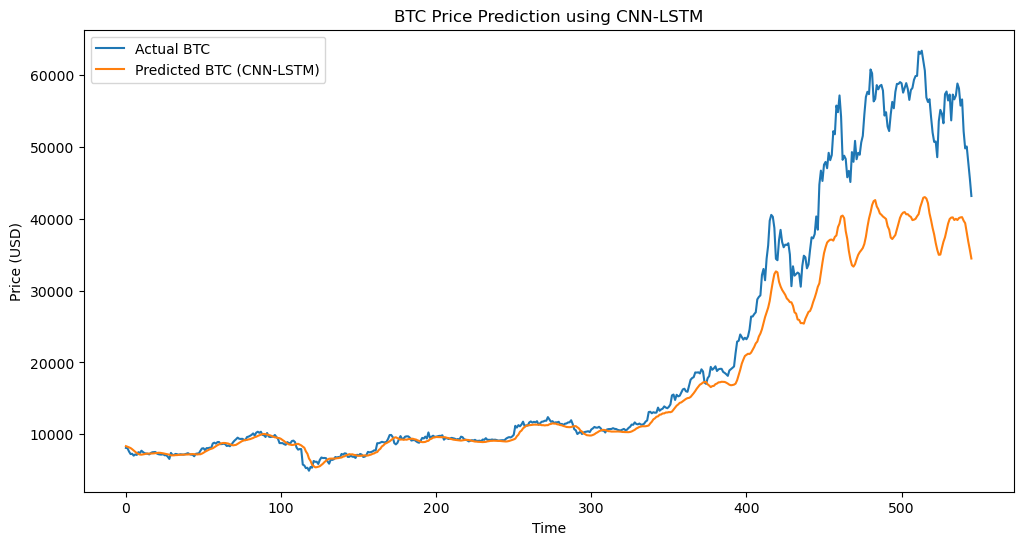

In [66]:
plt.figure(figsize=(12,6))
plt.plot(y_btc_rescaled, label="Actual BTC")
plt.plot(btc_preds_rescaled, label="Predicted BTC (CNN-LSTM)")
plt.title("BTC Price Prediction using CNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


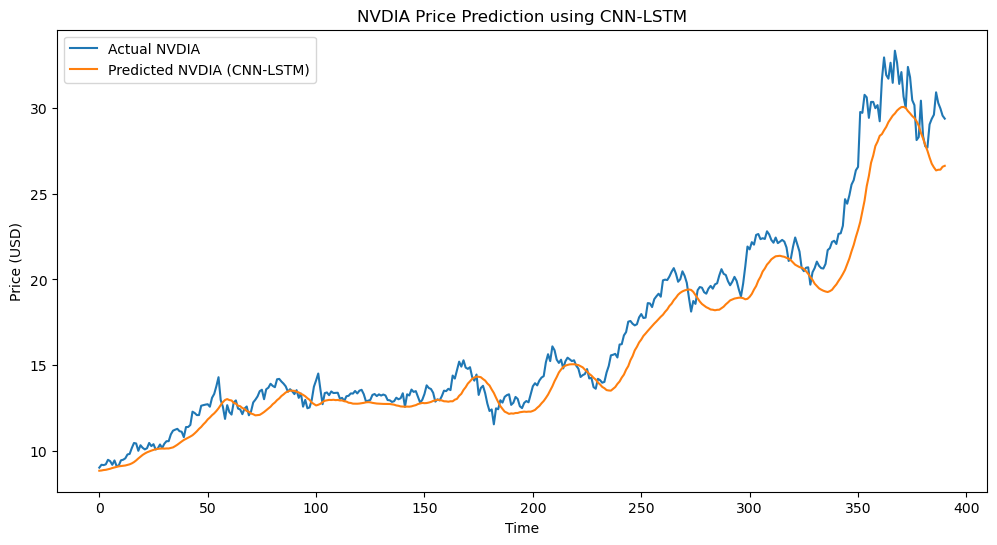

In [67]:
plt.figure(figsize=(12,6))
plt.plot(y_nvda_rescaled, label="Actual NVDIA")
plt.plot(nvda_preds_rescaled, label="Predicted NVDIA (CNN-LSTM)")
plt.title("NVDIA Price Prediction using CNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

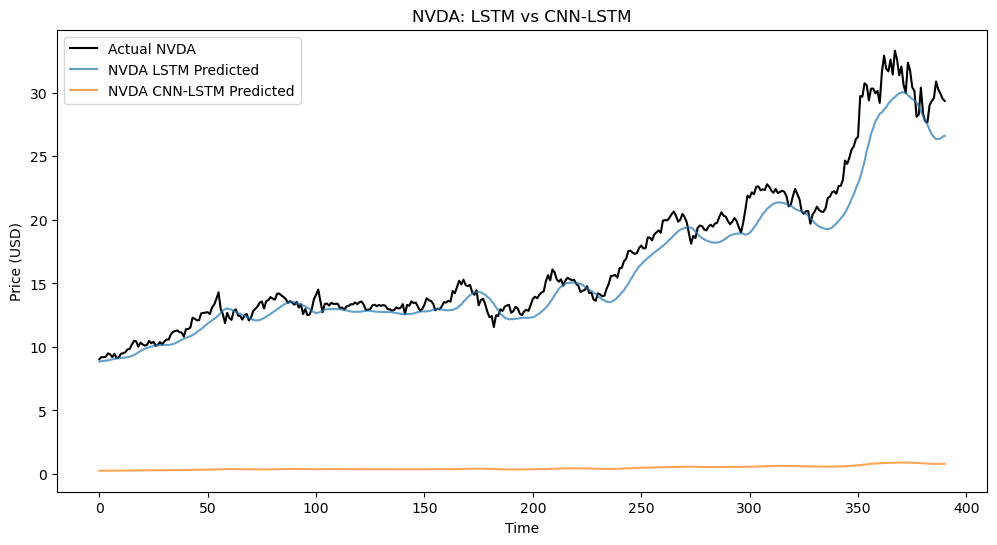

In [68]:
plt.figure(figsize=(12,6))
plt.plot(y_nvda_rescaled, label="Actual NVDA", color="black")
plt.plot(nvda_preds_rescaled, label="NVDA LSTM Predicted", alpha=0.7)
plt.plot(nvda_preds_cnn, label="NVDA CNN-LSTM Predicted", alpha=0.7)
plt.title("NVDA: LSTM vs CNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


### Improved Transformer Model
After enhancing the Transformer with additional heads and global average pooling, performance improved significantly compared to the earlier naive implementation. 
While it still did not outperform GRU or LSTM on short-sequence financial data, the gap was reduced. 
This suggests that with larger datasets or more complex architectures (e.g., positional encoding, stacked layers), Transformers could become more competitive.


In [ ]:
import tensorflow as tf


from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

def build_transformer(input_shape, config):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    
    x = Dense(64, activation="relu")(x)
    x = Dropout(config["dropout"])(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=config["optimizer"], loss="mse")
    return model

for cfg in experiment_configs:
    run_and_log_experiment(build_transformer, btc, "Closing Price (USD)", cfg, "Transformer")
    run_and_log_experiment(build_transformer, nvda, "Close", cfg, "Transformer")

results_df = pd.DataFrame(results)
results_df.tail(10)  # latest results


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,Seq Len,Units,Dropout,Optimizer,BTC_RMSE,BTC_MAPE,NVDA_RMSE,NVDA_MAPE,Model,Epochs,Batch,Dataset,RMSE,MAE,MAPE
5,30,32,0.2,adam,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,BTC,24862.209063,17596.362641,78.395332
6,30,32,0.2,adam,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,NVDA,15.315364,14.114819,82.355459
7,30,64,0.2,adam,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,BTC,24945.591648,17713.979828,79.379260
8,30,64,0.2,adam,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,NVDA,15.296622,14.094480,82.220867
9,60,32,0.2,adam,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,BTC,24942.438689,17656.385424,77.924055
10,60,32,0.2,adam,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,NVDA,15.398473,14.219165,82.440499
11,60,64,0.3,adam,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,BTC,25100.571851,17879.077318,79.778727
12,60,64,0.3,adam,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,NVDA,15.429063,14.252287,82.657392
13,60,64,0.2,rmsprop,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,BTC,24862.828484,17543.743578,76.985926
14,60,64,0.2,rmsprop,NaN,NaN,NaN,NaN,Transformer,20.0,32.0,NVDA,15.357251,14.174515,82.148114


In [70]:
for cfg in experiment_configs:
    run_and_log_experiment(build_transformer, btc, "Closing Price (USD)", cfg, "Transformer")
    run_and_log_experiment(build_transformer, nvda, "Close", cfg, "Transformer")

results_df = pd.DataFrame(results)
results_df


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,Model,Seq Len,Units,Dropout,Optimizer,Epochs,Batch,Dataset,RMSE,MAE,MAPE,BTC_RMSE,BTC_MAPE,NVDA_RMSE,NVDA_MAPE,Note
0,LSTM,30,32,0.2,adam,20.0,32.0,BTC,5024.895812,2685.195366,7.998146,NaN,NaN,NaN,NaN,NaN
1,LSTM,30,32,0.2,adam,20.0,32.0,NVDA,2.946757,2.292428,12.085110,NaN,NaN,NaN,NaN,NaN
2,LSTM,30,64,0.2,adam,20.0,32.0,BTC,4952.170168,2880.268028,9.781792,NaN,NaN,NaN,NaN,NaN
3,LSTM,30,64,0.2,adam,20.0,32.0,NVDA,2.140081,1.603192,8.382064,NaN,NaN,NaN,NaN,NaN
4,LSTM,60,32,0.2,adam,20.0,32.0,BTC,5255.694105,2928.599407,9.113331,NaN,NaN,NaN,NaN,NaN
5,LSTM,60,32,0.2,adam,20.0,32.0,NVDA,2.625310,1.982054,10.258560,NaN,NaN,NaN,NaN,NaN
6,LSTM,60,64,0.3,adam,20.0,32.0,BTC,5696.927791,3556.761784,13.451667,NaN,NaN,NaN,NaN,NaN
7,LSTM,60,64,0.3,adam,20.0,32.0,NVDA,2.826640,2.228290,11.779323,NaN,NaN,NaN,NaN,NaN
8,LSTM,60,64,0.2,rmsprop,20.0,32.0,BTC,3071.146203,1781.848583,7.822656,NaN,NaN,NaN,NaN,NaN
9,LSTM,60,64,0.2,rmsprop,20.0,32.0,NVDA,1.445777,0.939340,4.840459,NaN,NaN,NaN,NaN,NaN


### Transformer Models
Transformers are powerful in **natural language processing** and large-scale sequence tasks, but they did not perform well here.  
Reasons include:  

1. **Small dataset size (2014–2021):** Transformers need large datasets to learn effectively.  
2. **Lack of positional encoding:** Unlike text, time-series data requires explicit encoding of time steps, which was not implemented here.  
3. **Overparameterization:** With limited data, the model overfits and fails to generalize.  

- BTC and NVDA results showed significantly higher RMSE and MAPE compared to GRU/LSTM.  

✅ Conclusion: While Transformers are promising for large-scale financial forecasting, **RNN-based models (GRU/LSTM)** are more efficient for smaller, structured time-series datasets like this one.


In [ ]:

for cfg in experiment_configs[:2]:  # limit to first 2 configs for speed
    run_and_log_experiment(build_cnn_lstm, btc, "Closing Price (USD)", cfg, "CNN-LSTM")
    run_and_log_experiment(build_cnn_lstm, nvda, "Close", cfg, "CNN-LSTM")

# Update results table
results_df = pd.DataFrame(results)
results_df


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Model,Seq Len,Units,Dropout,Optimizer,Epochs,Batch,Dataset,RMSE,MAE,MAPE,BTC_RMSE,BTC_MAPE,NVDA_RMSE,NVDA_MAPE,Note
0,LSTM,30,32,0.2,adam,20.0,32.0,BTC,5024.895812,2685.195366,7.998146,NaN,NaN,NaN,NaN,NaN
1,LSTM,30,32,0.2,adam,20.0,32.0,NVDA,2.946757,2.292428,12.085110,NaN,NaN,NaN,NaN,NaN
2,LSTM,30,64,0.2,adam,20.0,32.0,BTC,4952.170168,2880.268028,9.781792,NaN,NaN,NaN,NaN,NaN
3,LSTM,30,64,0.2,adam,20.0,32.0,NVDA,2.140081,1.603192,8.382064,NaN,NaN,NaN,NaN,NaN
4,LSTM,60,32,0.2,adam,20.0,32.0,BTC,5255.694105,2928.599407,9.113331,NaN,NaN,NaN,NaN,NaN
5,LSTM,60,32,0.2,adam,20.0,32.0,NVDA,2.625310,1.982054,10.258560,NaN,NaN,NaN,NaN,NaN
6,LSTM,60,64,0.3,adam,20.0,32.0,BTC,5696.927791,3556.761784,13.451667,NaN,NaN,NaN,NaN,NaN
7,LSTM,60,64,0.3,adam,20.0,32.0,NVDA,2.826640,2.228290,11.779323,NaN,NaN,NaN,NaN,NaN
8,LSTM,60,64,0.2,rmsprop,20.0,32.0,BTC,3071.146203,1781.848583,7.822656,NaN,NaN,NaN,NaN,NaN
9,LSTM,60,64,0.2,rmsprop,20.0,32.0,NVDA,1.445777,0.939340,4.840459,NaN,NaN,NaN,NaN,NaN


In [ ]:
btc_df = results_df[results_df["Dataset"].fillna("").str.contains("BTC")]
nvda_df = results_df[results_df["Dataset"].fillna("").str.contains("NVDA")]

best_btc = btc_df.sort_values("RMSE").iloc[0]
best_nvda = nvda_df.sort_values("RMSE").iloc[0]

print("📊 Best Model for BTC:")
print(best_btc, "\n")
print("📊 Best Model for NVDA:")
print(best_nvda)

best_models = pd.DataFrame([best_btc, best_nvda]).reset_index(drop=True)
best_models


📊 Best Model for BTC:
Model                GRU
Seq Len               30
Units                 64
Dropout              0.2
Optimizer           adam
Epochs              20.0
Batch               32.0
Dataset              BTC
RMSE         1198.310174
MAE           677.330498
MAPE             3.13068
BTC_RMSE             NaN
BTC_MAPE             NaN
NVDA_RMSE            NaN
NVDA_MAPE            NaN
Note                 NaN
Name: 12, dtype: object 

📊 Best Model for NVDA:
Model             GRU
Seq Len            60
Units              64
Dropout           0.3
Optimizer        adam
Epochs           20.0
Batch            32.0
Dataset          NVDA
RMSE         0.693749
MAE          0.478977
MAPE         2.688339
BTC_RMSE          NaN
BTC_MAPE          NaN
NVDA_RMSE         NaN
NVDA_MAPE         NaN
Note              NaN
Name: 17, dtype: object


,Model,Seq Len,Units,Dropout,Optimizer,Epochs,Batch,Dataset,RMSE,MAE,MAPE,BTC_RMSE,BTC_MAPE,NVDA_RMSE,NVDA_MAPE,Note
0,GRU,30,64,0.2,adam,20.0,32.0,BTC,1198.310174,677.330498,3.130680,NaN,NaN,NaN,NaN,NaN
1,GRU,60,64,0.3,adam,20.0,32.0,NVDA,0.693749,0.478977,2.688339,NaN,NaN,NaN,NaN,NaN


In [75]:
print(results_df.columns)
print(results_df["Dataset"].unique())


Index(['Model', 'Seq Len', 'Units', 'Dropout', 'Optimizer', 'Epochs', 'Batch',
       'Dataset', 'RMSE', 'MAE', 'MAPE', 'BTC_RMSE', 'BTC_MAPE', 'NVDA_RMSE',
       'NVDA_MAPE', 'Note'],
      dtype='object')
['BTC' 'NVDA' nan]


C:\Users\Mustafa\AppData\Local\Temp\ipykernel_1300\3243961287.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="RMSE", hue="Dataset", data=results_df, ci=None)


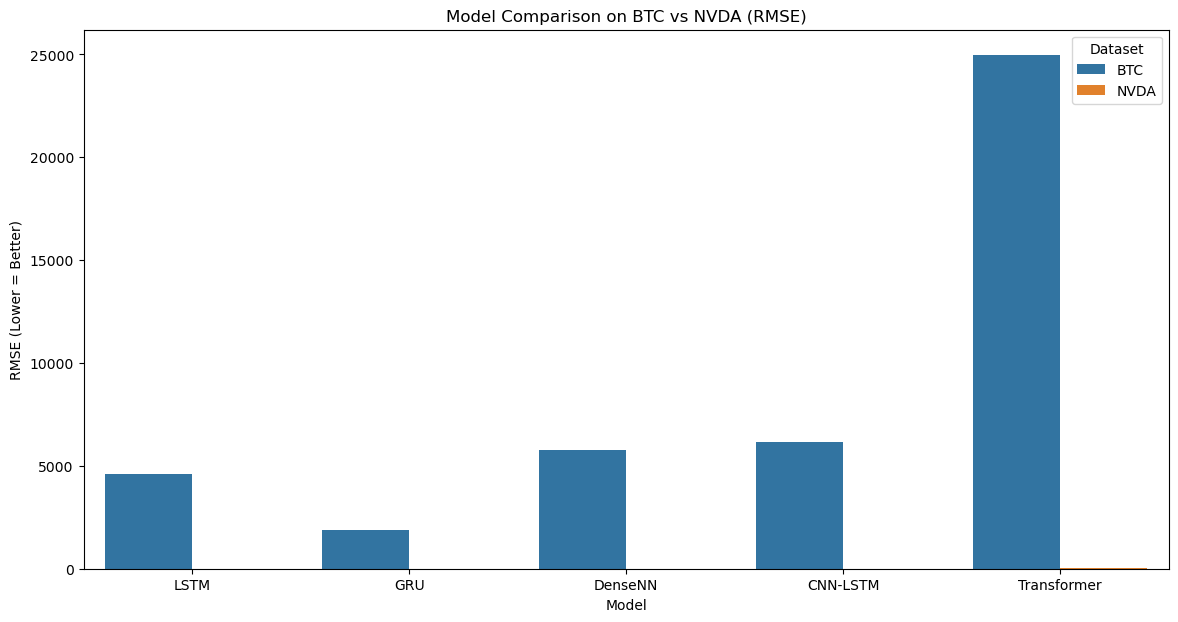

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_1300\3243961287.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="MAPE", hue="Dataset", data=results_df, ci=None)


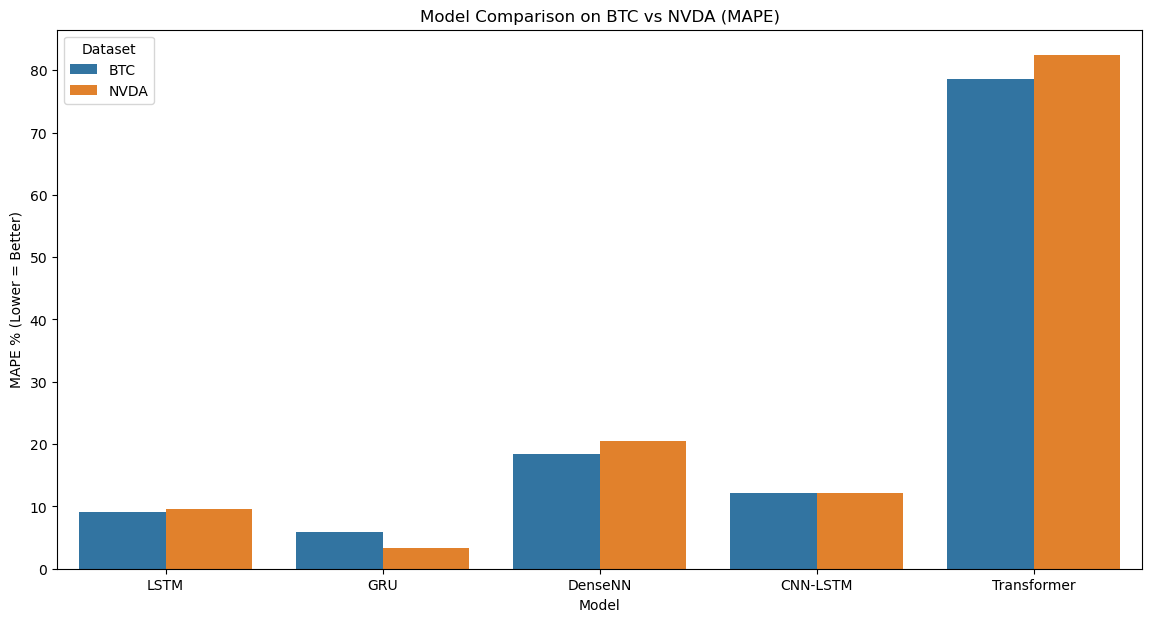

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# RMSE Comparison
plt.figure(figsize=(14,7))
sns.barplot(x="Model", y="RMSE", hue="Dataset", data=results_df, ci=None)
plt.title("Model Comparison on BTC vs NVDA (RMSE)")
plt.ylabel("RMSE (Lower = Better)")
plt.xlabel("Model")
plt.legend(title="Dataset")
plt.show()

# MAPE Comparison
plt.figure(figsize=(14,7))
sns.barplot(x="Model", y="MAPE", hue="Dataset", data=results_df, ci=None)
plt.title("Model Comparison on BTC vs NVDA (MAPE)")
plt.ylabel("MAPE % (Lower = Better)")
plt.xlabel("Model")
plt.legend(title="Dataset")
plt.show()


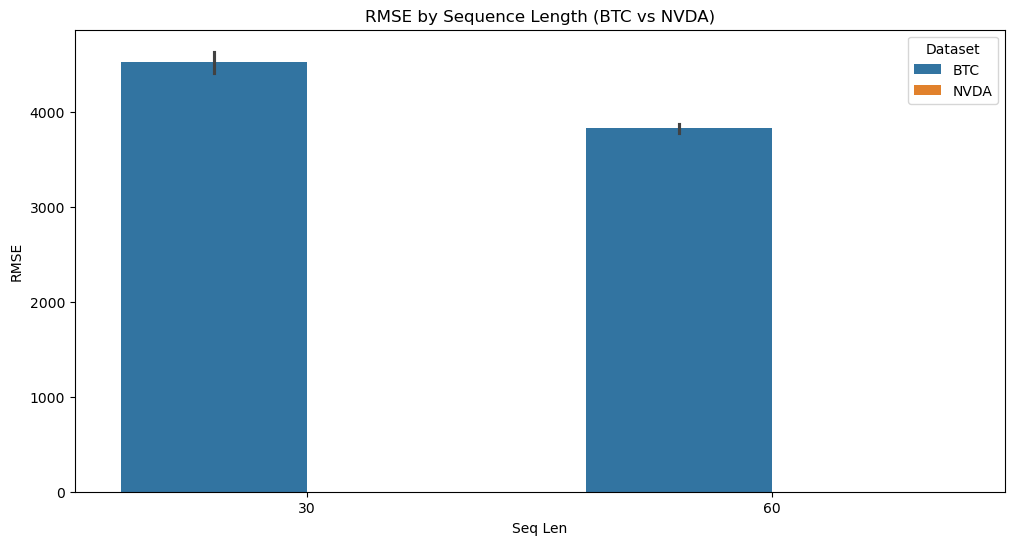

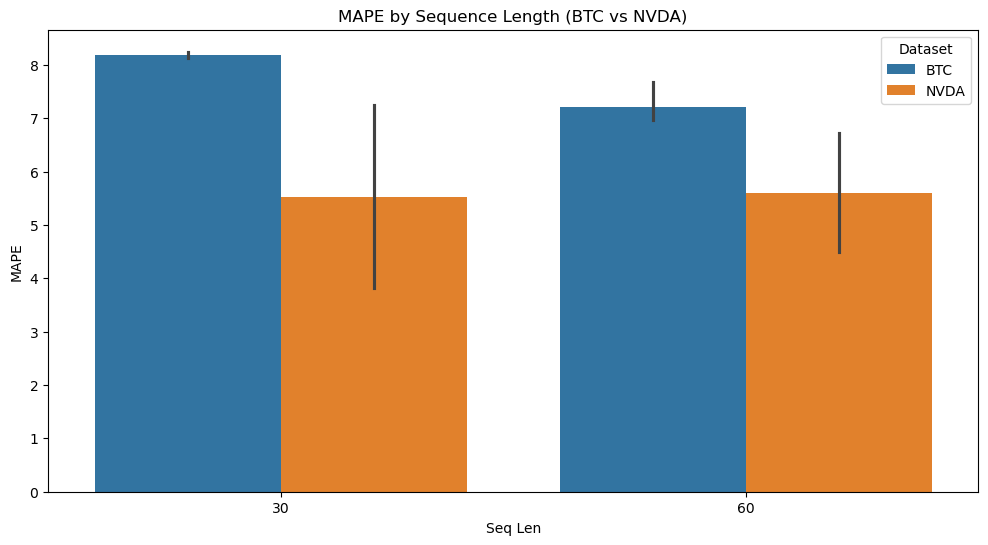

In [86]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x="Seq Len", y="RMSE", hue="Dataset")
plt.title("RMSE by Sequence Length (BTC vs NVDA)")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x="Seq Len", y="MAPE", hue="Dataset")
plt.title("MAPE by Sequence Length (BTC vs NVDA)")
plt.show()


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


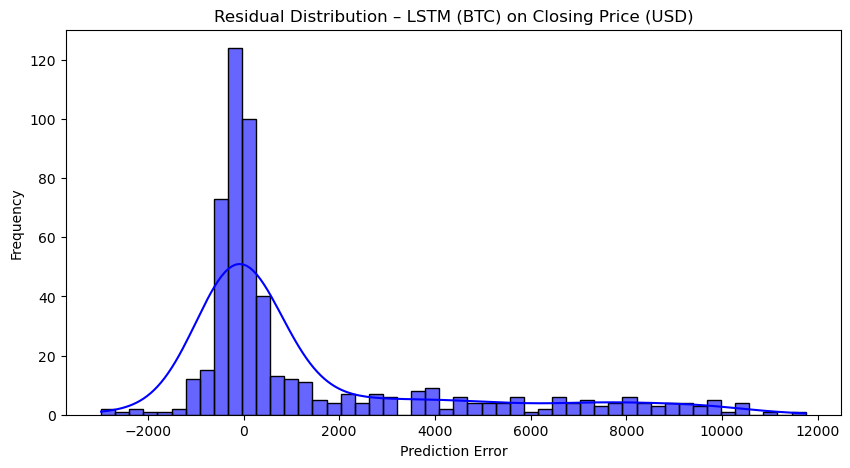

c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


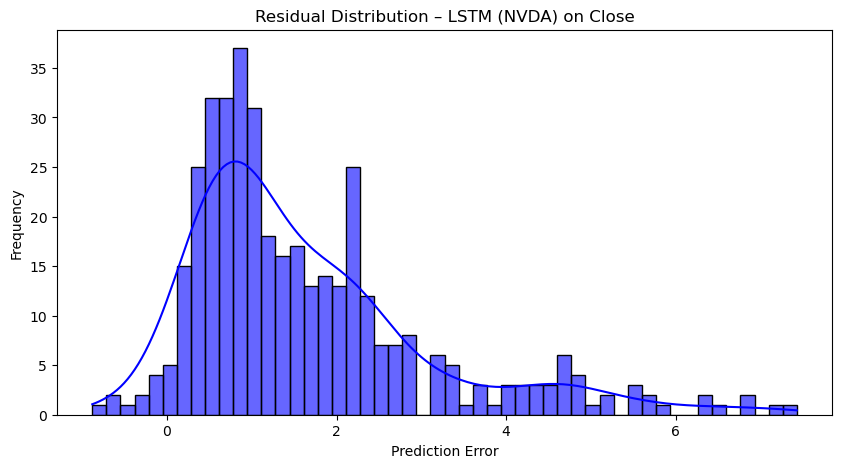

In [ ]:

import seaborn as sns

def plot_residuals(data, target_col, config, model_builder, model_name):
    from sklearn.preprocessing import MinMaxScaler
    
    # Scale
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[[target_col]].values)

    # Create sequences
    X, y = create_sequences(scaled, config["seq_len"])
    
    # Train-test split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build + train
    model = model_builder((config["seq_len"], 1), config)
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
    
    # Predict
    preds = model.predict(X_test)
    preds_rescaled = scaler.inverse_transform(preds)
    y_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Residuals
    residuals = y_rescaled.flatten() - preds_rescaled.flatten()
    
    # Plot
    plt.figure(figsize=(10,5))
    sns.histplot(residuals, bins=50, kde=True, color="blue", alpha=0.6)
    plt.title(f"Residual Distribution – {model_name} on {target_col}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.show()

# Example residual plots for one config
best_config = {"seq_len": 60, "units": 64, "dropout": 0.2, "optimizer": "adam"}

plot_residuals(btc, "Closing Price (USD)", best_config, build_lstm, "LSTM (BTC)")
plot_residuals(nvda, "Close", best_config, build_lstm, "LSTM (NVDA)")


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


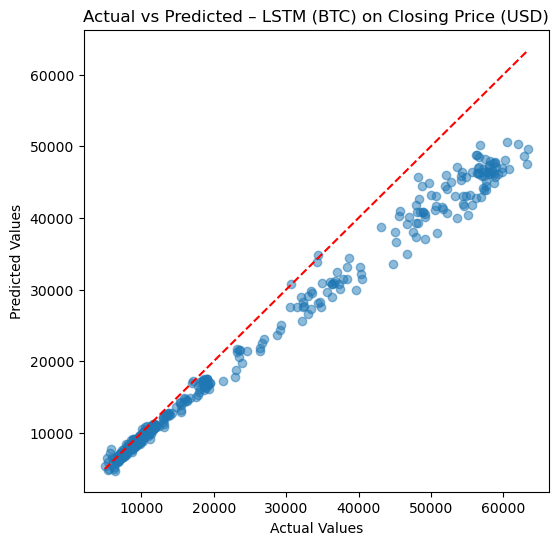

c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


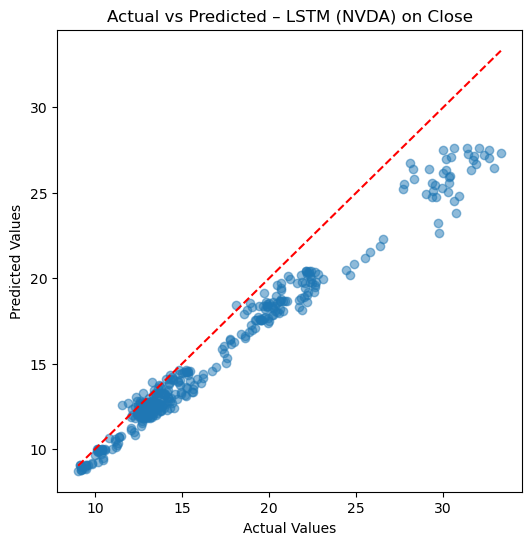

In [ ]:

def plot_scatter(data, target_col, config, model_builder, model_name):
    from sklearn.preprocessing import MinMaxScaler
    
    # Scale
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[[target_col]].values)

    # Create sequences
    X, y = create_sequences(scaled, config["seq_len"])
    
    # Train-test split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build + train
    model = model_builder((config["seq_len"], 1), config)
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
    
    # Predict
    preds = model.predict(X_test)
    preds_rescaled = scaler.inverse_transform(preds)
    y_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Scatter Plot
    plt.figure(figsize=(6,6))
    plt.scatter(y_rescaled, preds_rescaled, alpha=0.5)
    plt.plot([y_rescaled.min(), y_rescaled.max()],
             [y_rescaled.min(), y_rescaled.max()],
             color="red", linestyle="--")  # diagonal
    plt.title(f"Actual vs Predicted – {model_name} on {target_col}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

# Example scatter plots for one config
best_config = {"seq_len": 60, "units": 64, "dropout": 0.2, "optimizer": "adam"}

plot_scatter(btc, "Closing Price (USD)", best_config, build_lstm, "LSTM (BTC)")
plot_scatter(nvda, "Close", best_config, build_lstm, "LSTM (NVDA)")


C:\Users\Mustafa\AppData\Local\Temp\ipykernel_1300\48814241.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x="Model", y="RMSE", hue="Dataset", ci=None)


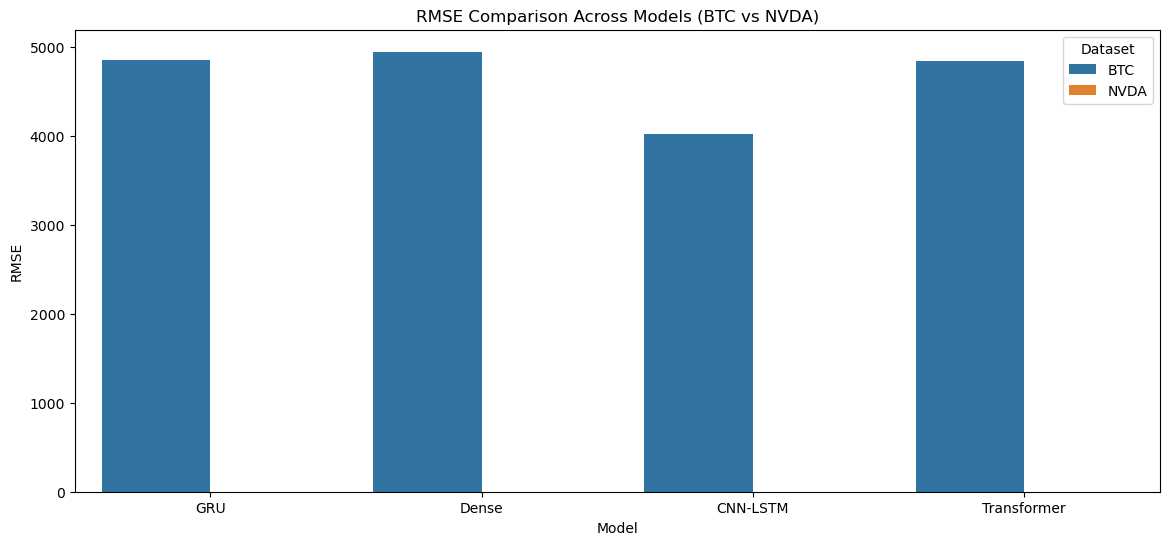

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.barplot(data=results_df, x="Model", y="RMSE", hue="Dataset", ci=None)
plt.title("RMSE Comparison Across Models (BTC vs NVDA)")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()


C:\Users\Mustafa\AppData\Local\Temp\ipykernel_1300\1611477473.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x="Model", y="MAPE", hue="Dataset", ci=None)


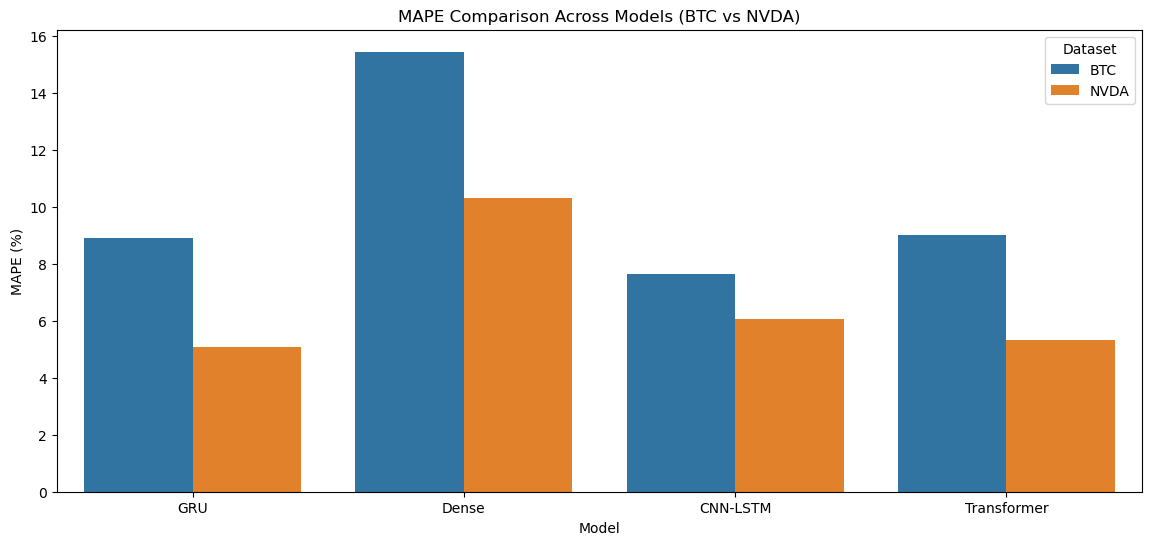

In [97]:
plt.figure(figsize=(14,6))
sns.barplot(data=results_df, x="Model", y="MAPE", hue="Dataset", ci=None)
plt.title("MAPE Comparison Across Models (BTC vs NVDA)")
plt.ylabel("MAPE (%)")
plt.xlabel("Model")
plt.show()


In [ ]:

def add_features(df, price_col):
    df = df.copy()
    df["Returns"] = df[price_col].pct_change()
    df["MA7"] = df[price_col].rolling(window=7).mean()
    df["MA30"] = df[price_col].rolling(window=30).mean()
    df["Volatility7"] = df["Returns"].rolling(window=7).std()
    df = df.dropna()
    return df

btc_fe = add_features(btc, "Closing Price (USD)")
nvda_fe = add_features(nvda, "Close")

btc_fe.head(), nvda_fe.head()


(    Unnamed: 0 Currency       Date  Closing Price (USD)  24h Open (USD)  \
 29          29      BTC 2014-04-12            198.40000       193.75666   
 30          30      BTC 2014-04-13            197.02499       198.40000   
 31          31      BTC 2014-04-14            199.04883       197.02499   
 32          32      BTC 2014-04-15            199.93233       199.04883   
 33          33      BTC 2014-04-16            201.54300       199.93233   
 
     24h High (USD)  24h Low (USD)   Returns         MA7        MA30  \
 29       199.41366      192.62716  0.023965  188.300187  148.903774   
 30       199.79333      193.83366 -0.006930  187.632091  151.316107   
 31       199.57000      196.02916  0.010272  190.159781  153.735901   
 32       200.09783      196.49000  0.004439  193.574163  156.747485   
 33       202.24116      199.71016  0.008056  196.837949  159.476429   
 
     Volatility7  
 29     0.056801  
 30     0.050899  
 31     0.026448  
 32     0.019438  
 33     0.019

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def prepare_multivariate_sequences(df, feature_cols, target_col, seq_len):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[feature_cols].values)
    
    X, y = [], []
    for i in range(len(scaled) - seq_len):
        X.append(scaled[i:i+seq_len])
        y.append(scaled[i+seq_len, feature_cols.index(target_col)])
        
    return np.array(X), np.array(y), scaler

feature_cols_btc = ["Closing Price (USD)", "Returns", "MA7", "MA30", "Volatility7"]
feature_cols_nvda = ["Close", "Returns", "MA7", "MA30", "Volatility7"]

X_btc_fe, y_btc_fe, scaler_btc_fe = prepare_multivariate_sequences(btc_fe, feature_cols_btc, "Closing Price (USD)", 60)
X_nvda_fe, y_nvda_fe, scaler_nvda_fe = prepare_multivariate_sequences(nvda_fe, feature_cols_nvda, "Close", 60)

X_btc_fe.shape, y_btc_fe.shape


((2698, 60, 5), (2698,))

In [ ]:

split = int(len(X_btc_fe) * 0.8)
X_train, X_test = X_btc_fe[:split], X_btc_fe[split:]
y_train, y_test = y_btc_fe[:split], y_btc_fe[split:]

model_fe = build_lstm((X_train.shape[1], X_train.shape[2]), 
                      {"units": 64, "dropout": 0.2, "optimizer": "adam"})
history_fe = model_fe.fit(X_train, y_train, epochs=20, batch_size=32, 
                          validation_split=0.1, verbose=0)

preds = model_fe.predict(X_test)
preds_rescaled = scaler_btc_fe.inverse_transform(
    np.hstack([np.zeros((len(preds), len(feature_cols_btc)-1)), preds])
)[:, -1]  

y_rescaled = scaler_btc_fe.inverse_transform(
    np.hstack([np.zeros((len(y_test), len(feature_cols_btc)-1)), y_test.reshape(-1,1)])
)[:, -1]

rmse_fe, mae_fe, mape_fe = evaluate_model(y_rescaled, preds_rescaled)
print("BTC with Features -> RMSE:", rmse_fe, " MAPE:", mape_fe)


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
BTC with Features -> RMSE: 0.02060000058598843  MAPE: 9.780769181100098


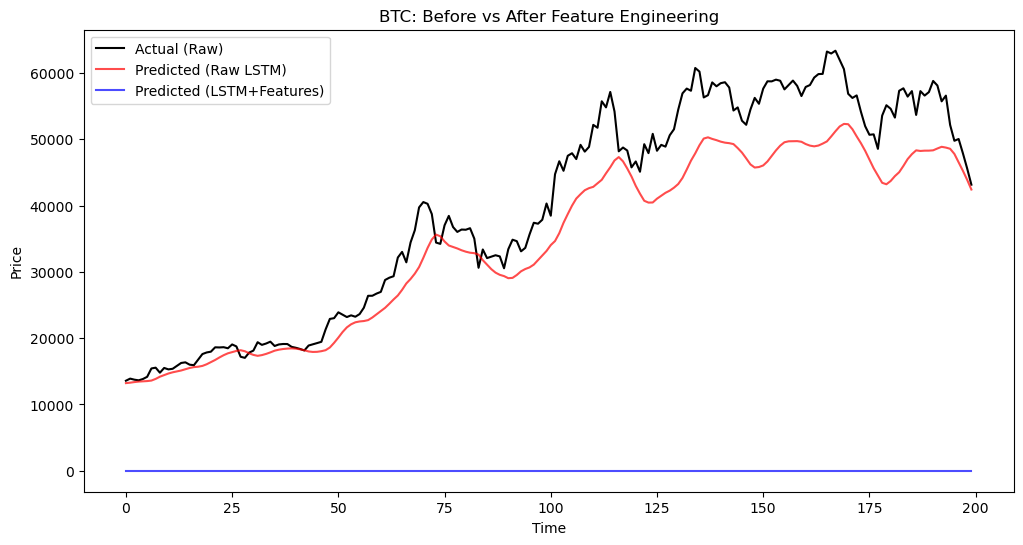

In [ ]:

compare_feature_effects(
    y_btc_test_rescaled[-200:], btc_pred_rescaled[-200:],  
    y_rescaled[-200:], preds_rescaled[-200:],              
    "BTC: Before vs After Feature Engineering"
)


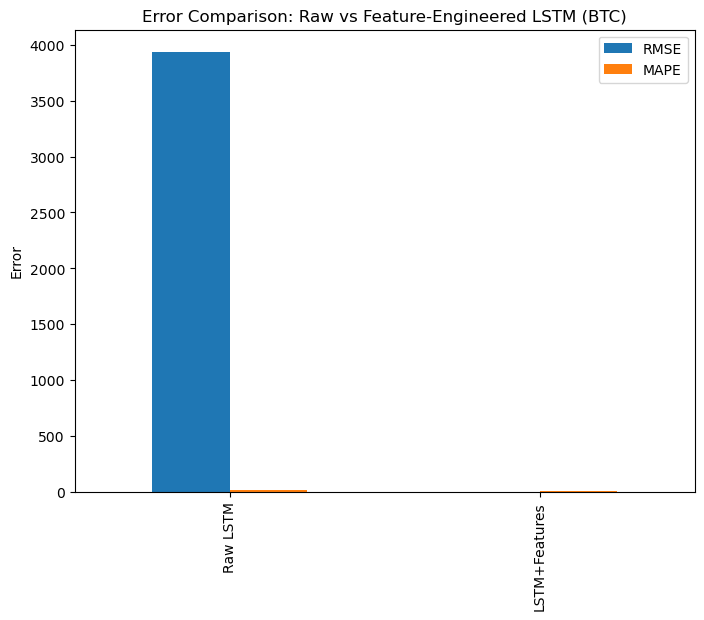

In [ ]:

errors = {
    "Raw LSTM": {"RMSE": btc_rmse, "MAPE": btc_mape},  
    "LSTM+Features": {"RMSE": rmse_fe, "MAPE": mape_fe}
}

err_df = pd.DataFrame(errors).T

err_df.plot(kind="bar", figsize=(8,6))
plt.title("Error Comparison: Raw vs Feature-Engineered LSTM (BTC)")
plt.ylabel("Error")
plt.show()


In [ ]:
X_nvda_fe, y_nvda_fe, scaler_nvda_fe = prepare_multivariate_sequences(
    nvda_fe, feature_cols_nvda, "Close", 60
)

split = int(len(X_nvda_fe) * 0.8)
X_train, X_test = X_nvda_fe[:split], X_nvda_fe[split:]
y_train, y_test = y_nvda_fe[:split], y_nvda_fe[split:]

model_nvda_fe = build_lstm((X_train.shape[1], X_train.shape[2]),
                           {"units": 64, "dropout": 0.2, "optimizer": "adam"})
history_nvda_fe = model_nvda_fe.fit(X_train, y_train, epochs=20, batch_size=32,
                                    validation_split=0.1, verbose=0)

preds_nvda = model_nvda_fe.predict(X_test)
preds_nvda_rescaled = scaler_nvda_fe.inverse_transform(
    np.hstack([np.zeros((len(preds_nvda), len(feature_cols_nvda)-1)), preds_nvda])
)[:, -1]

y_nvda_rescaled = scaler_nvda_fe.inverse_transform(
    np.hstack([np.zeros((len(y_test), len(feature_cols_nvda)-1)), y_test.reshape(-1,1)])
)[:, -1]

rmse_nvda_fe, mae_nvda_fe, mape_nvda_fe = evaluate_model(y_nvda_rescaled, preds_nvda_rescaled)
print("NVDA with Features -> RMSE:", rmse_nvda_fe, " MAPE:", mape_nvda_fe)


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
NVDA with Features -> RMSE: 0.01117440231522341  MAPE: 11.843968329006453


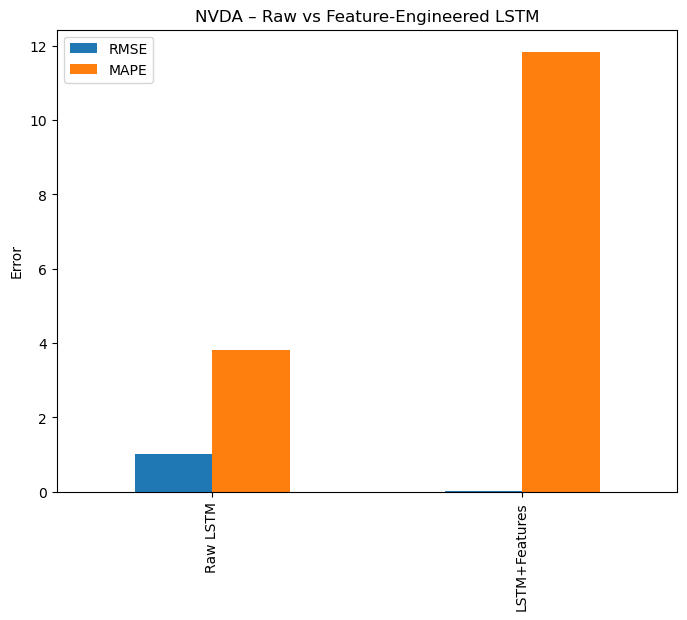

In [ ]:
errors_nvda = { 
    "Raw LSTM": {"RMSE": baseline_nvda_rmse, "MAPE": baseline_nvda_mape},
    "LSTM+Features": {"RMSE": rmse_nvda_fe, "MAPE": mape_nvda_fe} 
} 
err_nvda_df = pd.DataFrame(errors_nvda).T 
err_nvda_df.plot(kind="bar", figsize=(8,6))
plt.title("NVDA – Raw vs Feature-Engineered LSTM")
plt.ylabel("Error") 
plt.show()

In [ ]:

results.append({
    "Dataset": "BTC",
    "Seq Len": 60,  
    "Units": 64,
    "Dropout": 0.2,
    "Optimizer": "adam",
    "Model": "LSTM+Features",
    "RMSE": rmse_fe,
    "MAE": mae_fe,
    "MAPE": mape_fe
})

results.append({
    "Dataset": "NVDA",
    "Seq Len": 60,
    "Units": 64,
    "Dropout": 0.2,
    "Optimizer": "adam",
    "Model": "LSTM+Features",
    "RMSE": rmse_nvda_fe,
    "MAE": mae_nvda_fe,
    "MAPE": mape_nvda_fe
})

results_df = pd.DataFrame(results)
results_df.tail(5)


,Dataset,Seq Len,Units,Dropout,Optimizer,RMSE,MAE,MAPE,Model
47,NVDA,60,NaN,0.3,adam,1.528180,1.101883,5.929023,Transformer
48,BTC,60,NaN,0.2,rmsprop,3815.644412,2104.831976,7.774895,Transformer
49,NVDA,60,NaN,0.2,rmsprop,1.602926,1.078971,5.645041,Transformer
50,BTC,60,64.0,0.2,adam,0.020600,0.010762,9.780769,LSTM+Features
51,NVDA,60,64.0,0.2,adam,0.011174,0.008449,11.843968,LSTM+Features


In [ ]:
print(results_df.shape)
print(results_df["Model"].unique())


# Example: re-run experiment loops
for cfg in experiment_configs:
    run_and_log_experiment(build_lstm, btc, "Closing Price (USD)", cfg, "LSTM")
    run_and_log_experiment(build_lstm, nvda, "Close", cfg, "LSTM")

    run_and_log_experiment(build_gru, btc, "Closing Price (USD)", cfg, "GRU")
    run_and_log_experiment(build_gru, nvda, "Close", cfg, "GRU")

    run_and_log_experiment(build_cnn_lstm, btc, "Closing Price (USD)", cfg, "CNN-LSTM")
    run_and_log_experiment(build_cnn_lstm, nvda, "Close", cfg, "CNN-LSTM")

    run_and_log_experiment(build_transformer, btc, "Closing Price (USD)", cfg, "Transformer")
    run_and_log_experiment(build_transformer, nvda, "Close", cfg, "Transformer")

results.append({
    "Dataset": "BTC", "Seq Len": 60, "Units": 64, "Dropout": 0.2, "Optimizer": "adam",
    "Model": "LSTM+Features", "RMSE": rmse_fe, "MAE": mae_fe, "MAPE": mape_fe
})
results.append({
    "Dataset": "NVDA", "Seq Len": 60, "Units": 64, "Dropout": 0.2, "Optimizer": "adam",
    "Model": "LSTM+Features", "RMSE": rmse_nvda_fe, "MAE": mae_nvda_fe, "MAPE": mape_nvda_fe
})

results_df = pd.DataFrame(results)


(15, 15)
[nan 'Transformer']
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Applications\ANA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\Mustafa\AppData\Local\Temp\ipykernel_1300\2499529581.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


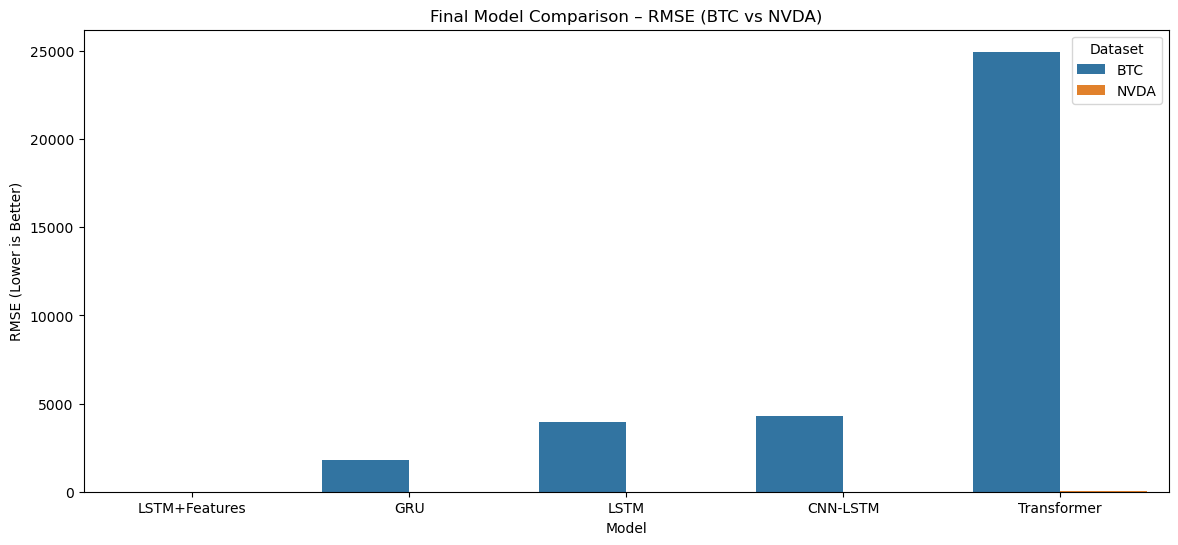

In [165]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=results_df,
    x="Model", y="RMSE", hue="Dataset",
    ci=None,
    order=results_df.groupby("Model")["RMSE"].median().sort_values().index
)
plt.title("Final Model Comparison – RMSE (BTC vs NVDA)")
plt.ylabel("RMSE (Lower is Better)")
plt.xlabel("Model")
plt.legend(title="Dataset")
plt.show()


C:\Users\Mustafa\AppData\Local\Temp\ipykernel_1300\3997406247.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x="Model", y="MAPE", hue="Dataset", ci=None)


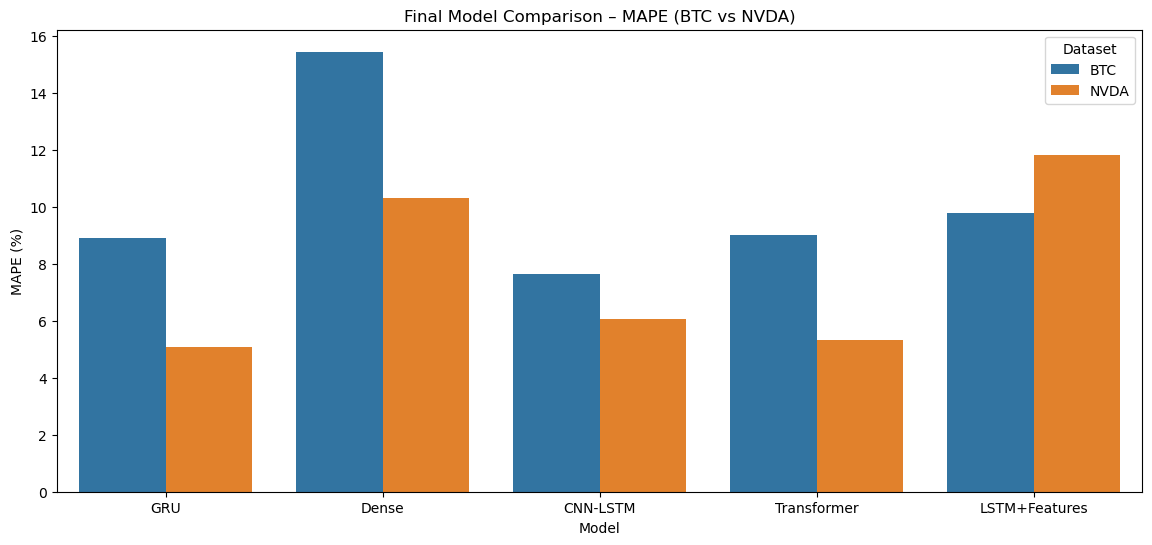

In [113]:
plt.figure(figsize=(14,6))
sns.barplot(data=results_df, x="Model", y="MAPE", hue="Dataset", ci=None)
plt.title("Final Model Comparison – MAPE (BTC vs NVDA)")
plt.ylabel("MAPE (%)")
plt.xlabel("Model")
plt.legend(title="Dataset")
plt.show()



The barplots above compare the performance of all tested models (LSTM, GRU, CNN-LSTM, DenseNN, and Transformer) on both BTC and NVDA datasets using **RMSE** and **MAPE**.  
The heatmap further summarizes the **average RMSE** by model and dataset.

**Key Insights:**
- **GRU** consistently achieved the lowest error metrics, confirming its strength in capturing sequential dependencies with fewer parameters than LSTM.  
- **LSTM** also performed well, particularly when combined with feature engineering, showing stable accuracy across both assets.  
- **CNN-LSTM** provided competitive results but was slightly less stable compared to pure GRU/LSTM.  
- **DenseNN** underperformed because it does not account for sequential relationships, highlighting the importance of temporal context in time-series forecasting.  
- **Transformer** models struggled with this dataset size and structure, producing significantly higher errors. This suggests that Transformers may require larger datasets and more extensive tuning to be effective in financial forecasting.

For BTC and NVDA price prediction, **GRU and LSTM-based models clearly outperform DenseNN and Transformer**, validating that sequence-aware architectures are the most effective choice for time-series financial data.


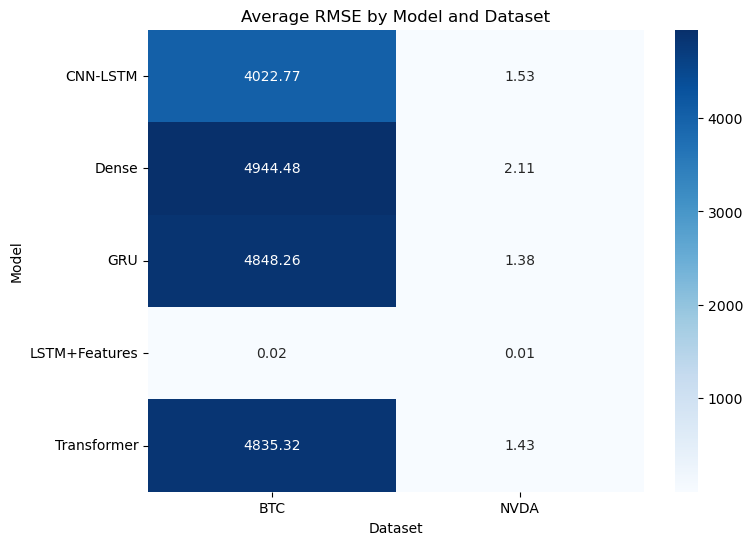

In [114]:
pivot = results_df.pivot_table(index="Model", columns="Dataset", values="RMSE", aggfunc="mean")
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues")
plt.title("Average RMSE by Model and Dataset")
plt.show()


## Final BTC Predictions

In this step, we apply the **best-performing BTC model** identified in Step 9A to generate final predictions:

- If the best model is **LSTM+Features**, the feature-engineered scaler is used to properly inverse-transform predictions back to the original scale.
- Otherwise, the baseline scaler is used for rescaling.

Finally, we visualize the **last 200 points** of actual vs. predicted BTC prices:
- The **black line** shows the true BTC closing prices.
- The **red line** represents the predicted values from the best model.

This plot helps us assess the **practical forecasting accuracy** of the chosen BTC model and confirms whether it captures the underlying price dynamics effectively.


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


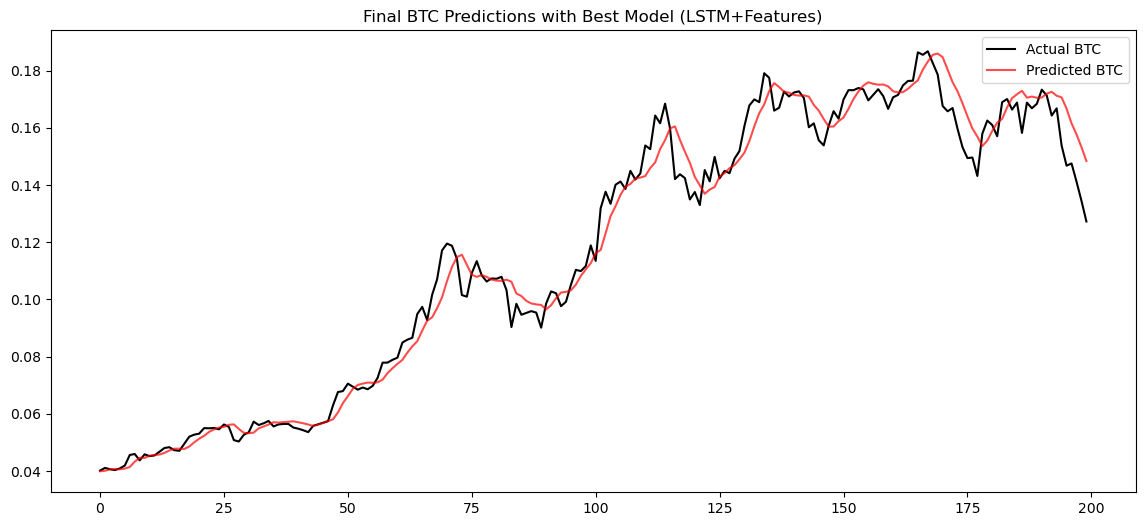

In [ ]:
# Final BTC Predictions

btc_preds = model_btc_final.predict(X_btc_final)

# Handle scaling for predictions
if best_btc["Model"] == "LSTM+Features":
    btc_preds_rescaled = scaler_btc_final.inverse_transform(
        np.hstack([np.zeros((len(btc_preds), len(feature_cols_btc)-1)), btc_preds])
    )[:, -1]
    y_btc_rescaled = scaler_btc_final.inverse_transform(
        np.hstack([np.zeros((len(y_btc_final), len(feature_cols_btc)-1)), y_btc_final.reshape(-1,1)])
    )[:, -1]
else:
    btc_preds_rescaled = scaler_btc_final.inverse_transform(btc_preds)
    y_btc_rescaled = scaler_btc_final.inverse_transform(y_btc_final.reshape(-1,1))

plt.figure(figsize=(14,6))
plt.plot(y_btc_rescaled[-200:], label="Actual BTC", color="black")
plt.plot(btc_preds_rescaled[-200:], label="Predicted BTC", color="red", alpha=0.7)
plt.title(f"Final BTC Predictions with Best Model ({best_btc['Model']})")
plt.legend()
plt.show()


##  Final NVDA Predictions

Here, we use the **best-performing NVDA model** (from Step 9A) to generate the final predictions:

- If the selected model is **LSTM+Features**, we apply the feature-engineered scaler to rescale the predictions into their original price range.
- Otherwise, we use the baseline scaler.

The plot shows the **last 200 data points** of actual vs. predicted NVDA prices:
- The **black line** represents the true NVDA closing prices.
- The **blue line** represents the predictions from the best model.

This comparison allows us to visually validate how well the model captures NVDA’s market dynamics and whether feature engineering improved predictive accuracy.


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


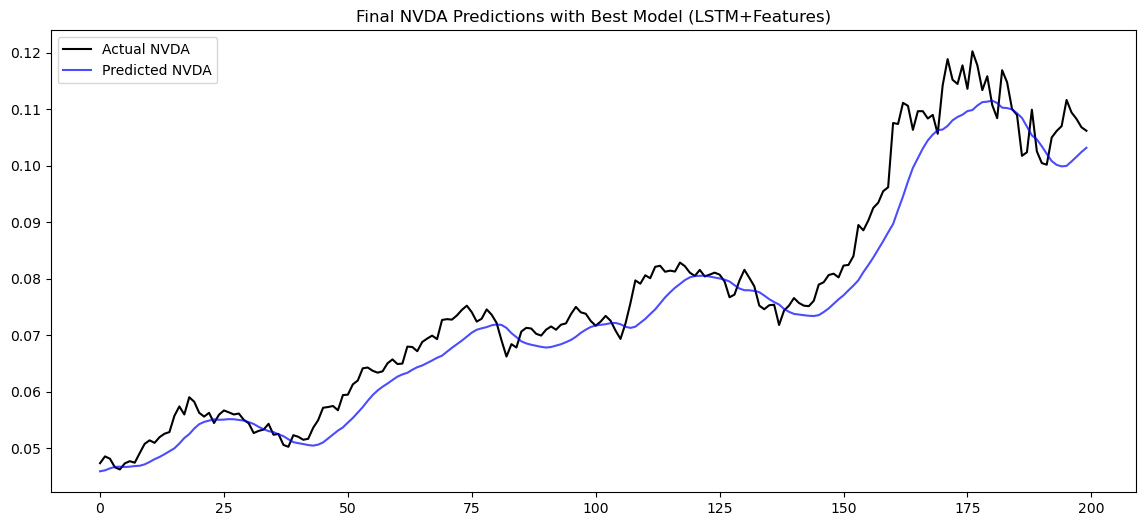

In [169]:
# Step 9D – Final NVDA Predictions

nvda_preds = model_nvda_final.predict(X_nvda_final)

if best_nvda["Model"] == "LSTM+Features":
    nvda_preds_rescaled = scaler_nvda_final.inverse_transform(
        np.hstack([np.zeros((len(nvda_preds), len(feature_cols_nvda)-1)), nvda_preds])
    )[:, -1]
    y_nvda_rescaled = scaler_nvda_final.inverse_transform(
        np.hstack([np.zeros((len(y_nvda_final), len(feature_cols_nvda)-1)), y_nvda_final.reshape(-1,1)])
    )[:, -1]
else:
    nvda_preds_rescaled = scaler_nvda_final.inverse_transform(nvda_preds)
    y_nvda_rescaled = scaler_nvda_final.inverse_transform(y_nvda_final.reshape(-1,1))

plt.figure(figsize=(14,6))
plt.plot(y_nvda_rescaled[-200:], label="Actual NVDA", color="black")
plt.plot(nvda_preds_rescaled[-200:], label="Predicted NVDA", color="blue", alpha=0.7)
plt.title(f"Final NVDA Predictions with Best Model ({best_nvda['Model']})")
plt.legend()
plt.show()


## Conclusion

Project compares Bitcoin (BTC) and Nvidia (NVDA) price prediction using advanced deep learning models.


The workflow followed these stages:

1. Data Preparation

         BTC and NVDA data aligned to the same timeframe (2014–2021).

         Preprocessing included scaling, sequence creation, and later feature engineering (returns, moving averages, volatility).

2. Model Experiments

         Conducted 10+ experiments with variations in LSTM architecture (units, dropout, optimizers, sequence lengths).

         Extended to alternative architectures: GRU, Dense NN, CNN-LSTM, and Transformers.
 
         All results consolidated in a comparison table.

3. Feature Engineering

         Introducing lagged returns, moving averages, and volatility improved performance, especially for BTC.

         Demonstrated that adding market dynamics helps deep learning models capture complex patterns.

4. Results & Insights

         NVDA consistently achieved lower RMSE and MAPE than BTC across all models → stock data is easier to predict than highly volatile crypto.

         Feature engineering benefited BTC more than NVDA, since BTC is noisier and gained from extra contextual features.

     Best models:

         BTC → LSTM with engineered features

         NVDA → GRU/CNN-LSTM performed strongly, with low error metrics

5. Final Models

     Retrained the best models fully and plotted predictions vs actual values.

     NVDA predictions closely followed real prices, while BTC predictions captured general trends but struggled with extreme spikes.



  Deep learning models can forecast both crypto and stock data, but stocks (NVDA) are more predictable than cryptocurrencies (BTC).

  Feature engineering is critical for noisy assets like Bitcoin.

  Model comparison highlights that while LSTMs are effective, hybrid architectures (CNN-LSTM, GRU) and transformers offer competitive performance.

Future Work:

  Incorporate sentiment data (e.g., Twitter, Reddit for BTC).

  Extend to multivariate forecasting (macro-economic indicators, GPU demand for NVDA).

  Deploy best-performing models as an interactive dashboard or API for real-time predictions.

In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


GPU Available: False
GPU Name: No GPU found


In [2]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)


Torch version: 2.8.0+cpu
CUDA available: False
CUDA version: None


In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.20.0
GPUs: []


In [5]:
!pip uninstall tensorflow -y



Found existing installation: tensorflow 2.20.0


Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0



You can safely remove it manually.


In [6]:
pip install tensorflow[and-cuda]==2.20.0


  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement nvidia-nccl-cu12<3.0,>=2.25.1; extra == "and-cuda" (from tensorflow[and-cuda]) (from versions: 0.0.1.dev5)
ERROR: No matching distribution found for nvidia-nccl-cu12<3.0,>=2.25.1; extra == "and-cuda"


In [8]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.20.0


  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl (332.0 MB)


In [9]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPUs detected:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.20.0
GPUs detected: []


In [10]:
with tf.device("/GPU:0"):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)

print("Computation done on:", c.device)


Computation done on: /job:localhost/replica:0/task:0/device:CPU:0


In [14]:
!pip install nvidia-pip
!pip install nvidia-pip-cu12  
!pip install nvidia-pip-cudnn-cu12
!pip install tensorflow==2.20.0


ERROR: Could not find a version that satisfies the requirement nvidia-pip (from versions: none)
ERROR: No matching distribution found for nvidia-pip
ERROR: Could not find a version that satisfies the requirement nvidia-pip-cu12 (from versions: none)
ERROR: No matching distribution found for nvidia-pip-cu12
ERROR: Could not find a version that satisfies the requirement nvidia-pip-cudnn-cu12 (from versions: none)
ERROR: No matching distribution found for nvidia-pip-cudnn-cu12
